# Performance analysis

## 1. Import libraries

In [ ]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import importlib
import detection_analysis
from detection_analysis import analyze_tp_fp_fn, visualize_tp_fp_fn_analysis, plot_training_loss_curves, plot_training_metrics_curves, run_stream_predictions_to_json, basic_statistics

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Setup

In [2]:
# EXP NAME
EXP_NAME = "yolov26m-default-imgz1280_DeTect20002"

# BASE routes
BASE_DIR = Path('.')
RUNS_DIR = Path('DeTect-BMMS/runs') / EXP_NAME
WEIGHTS_DIR = RUNS_DIR / 'weights'
RESULTS_DIR = RUNS_DIR

# Configuration
DATA_YAML = 'cfg/datasets/DeTect.yaml'
IMGSZ = 1280
CONF_THRESHOLD_DEFAULT = 0.5

# Create directories if they don't exist
RUNS_DIR.mkdir(parents=True, exist_ok=True)
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Experiment: {EXP_NAME}")
print(f"Results directory: {RUNS_DIR}")
print(f"Weights saved in: {WEIGHTS_DIR}")

# Check for file existence
best_weights = WEIGHTS_DIR / 'best.pt'
if best_weights.exists():
    print(f"✓ Model found: {best_weights}")
else:
    print(f"✗ Model NOT found: {best_weights}")
    
results_csv = RESULTS_DIR / 'results.csv'
if results_csv.exists():
    print(f"✓ Results found: {results_csv}")
else:
    print(f"✗ Results NOT found: {results_csv}")

Experiment: yolov26m-default-imgz1280_DeTect20002
Results directory: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002
Weights saved in: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/weights
✓ Model found: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/weights/best.pt
✓ Results found: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/results.csv


## 3. Cargar Modelo Entrenado

In [3]:
# Load model
model = YOLO(str(WEIGHTS_DIR / 'best.pt'))
print(f"✓ Modelo cargado: {WEIGHTS_DIR / 'best.pt'}")
print(f"Image size: {IMGSZ}")
print(f"Device: {model.device}")
model.info()

✓ Modelo cargado: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/weights/best.pt
Image size: 1280
Device: cpu
YOLO26l summary: 392 layers, 26,177,886 parameters, 0 gradients, 93.1 GFLOPs


(392, 26177886, 0, 93.11825920000001)

## 4. Training curves

### Losses

In [ ]:
# Load results.csv
results_csv_path = RESULTS_DIR / 'results.csv'

if results_csv_path.exists():
    results_df = pd.read_csv(results_csv_path)
    # Clean whitespace from column names
    results_df.columns = results_df.columns.str.strip()
    print(f"✓ Results loaded: {len(results_df)} epochs")
    print(f"\nAvailable columns:")
    print(results_df.columns.tolist())
else:
    print(f"✗ Results file not found: {results_csv_path}")
    results_df = None

plot_training_loss_curves(results_df, RESULTS_DIR)

✓ Results loaded: 21 epochs

Available columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2', 'lr/pg3', 'lr/pg4', 'lr/pg5', 'lr/pg6', 'lr/pg7']

Last 5 epochs:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2,lr/pg3,lr/pg4,lr/pg5,lr/pg6,lr/pg7
16,17,3411.72,1.44263,0.72547,0.00072,0.81268,0.80074,0.84046,0.33769,1.93161,0.92655,0.00150,0.004812,0.001604,0.004812,0.001604,0.004812,0.001604,0.004812,0.001604
17,18,3610.33,1.44633,0.70692,0.00073,0.80488,0.77519,0.81123,0.33951,1.92377,0.97209,0.00149,0.004738,0.001579,0.004738,0.001579,0.004738,0.001579,0.004738,0.001579
18,19,3809.17,1.45048,0.69546,0.00069,0.76021,0.79792,0.81647,0.33047,1.99508,0.91575,0.00156,0.004664,0.001554,0.004664,0.001554,0.004664,0.001554,0.004664,0.001554
19,20,4007.12,1.36983,0.64904,0.00067,0.76493,0.78859,0.82251,0.30516,2.00882,0.96352,0.00165,0.004589,0.001530,0.004589,0.001530,0.004589,0.001530,0.004589,0.001530
20,21,4205.12,1.37423,0.62634,0.00069,0.84212,0.78859,0.85323,0.33941,2.06336,0.84078,0.00163,0.004515,0.001505,0.004515,0.001505,0.004515,0.001505,0.004515,0.001505


### (Mean Average Precision) and Precision-Recall

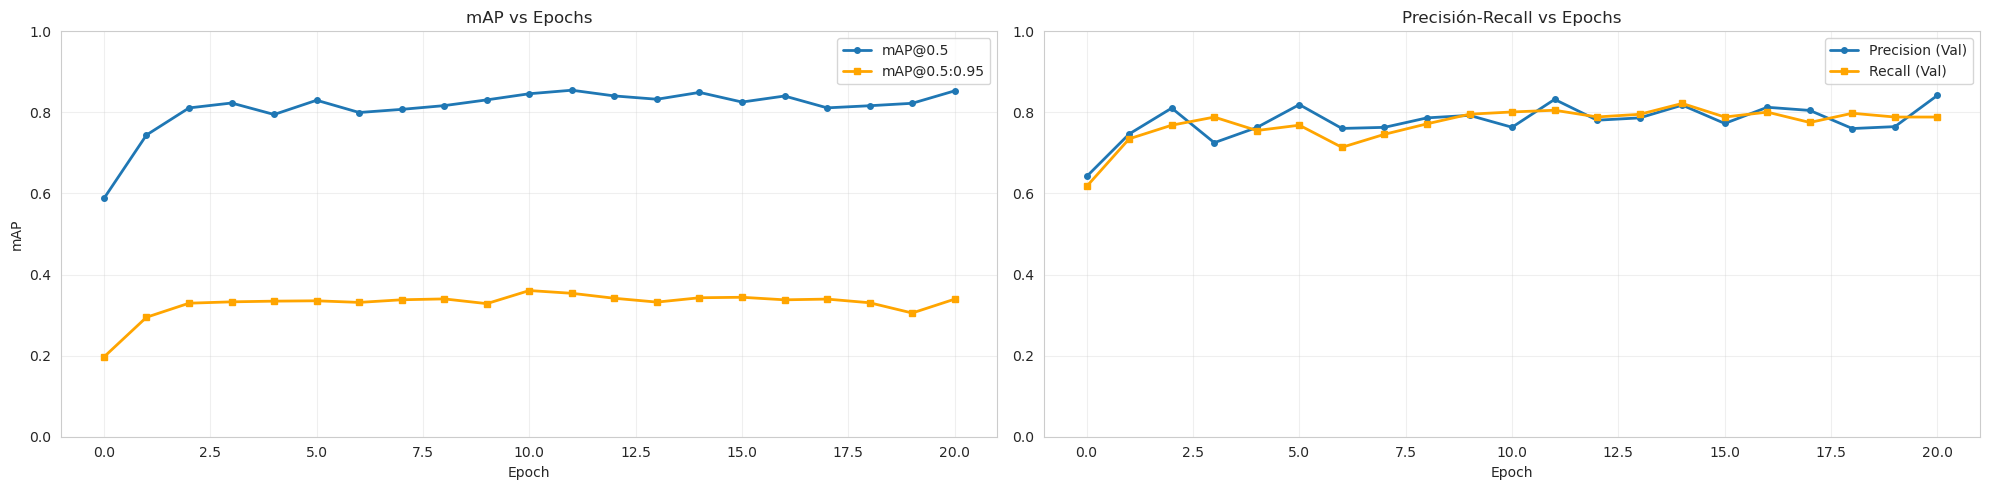

✓ mAP-PR plots saved

Best mAP@0.5: 0.8548 at epoch 11
Best mAP@0.5:0.95: 0.3606 at epoch 10

Best Precision: 0.8421 at epoch 20
Best Recall: 0.8222 at epoch 14


In [ ]:
plot_training_metrics_curves(results_df, RESULTS_DIR)

# Best model evaluation

### Validation

Running evaluation on validation set...


Processing predictions...
  Processed 500 images...
  Processed 1000 images...
  Processed 1500 images...
  Processed 2000 images...
  Processed 2500 images...
  Processed 3000 images...
Results saved to /home/detect/DeTect_TaiwanBirds_VideoDetector/deep_learning/runs/detect/predict17
Saved 3265 predictions to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_predictions.json
✓ Validation predictions completed.
✓ Images processed: 3265
✓ Validation predictions saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_predictions.json
✓ Validation predictions loaded: 3265 images

--- Statistics ---
Total images: 3265
Images with detections: 1024
Images without detections: 2241
Total detections: 2722
Average detections per image: 0.83

--- Confidence Scores ---
Min: 0.0100
Max: 0.8861
Mean: 0.1059
Median: 0.0312
Std Dev: 0.1602


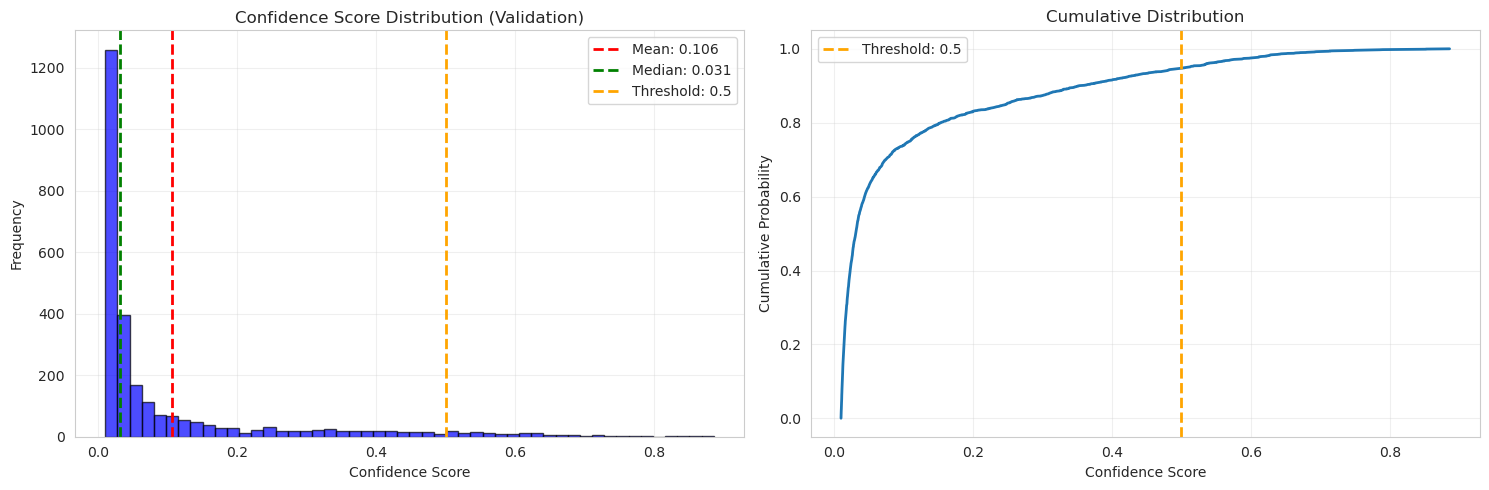

✓ Confidence distribution plots saved

--- Predictions by Confidence Range ---
0.00 - 0.25: 2321 predictions (85.3%)
0.25 - 0.50: 258 predictions (9.5%)
0.50 - 0.75: 132 predictions (4.8%)
0.75 - 1.00: 11 predictions (0.4%)


In [9]:
print("Running evaluation on validation set...")
print("=" * 80)

val_txt_file = "/home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/val/val_92.3-7.7.txt"
val_predictions_path = RESULTS_DIR / "val_predictions.json"

val_pred_count = run_stream_predictions_to_json(
    model=model,
    source=val_txt_file,
    output_path=val_predictions_path,
    conf=0.01,
    imgsz=IMGSZ,
    batch=1,
    device="cuda",
    save=True,
    stream=True,
    verbose=False,
)

print("✓ Validation predictions completed.")
print(f"✓ Images processed: {val_pred_count}")
print(f"✓ Validation predictions saved to: {val_predictions_path}")

val_predictions = load_predictions_grouped(val_predictions_path)
if val_predictions:
    print(f"✓ Validation predictions loaded: {len(val_predictions)} images")

    basic_statistics(val_predictions)
else:
    print(f"✗ Predictions file not found: {val_predictions_path}")

In [10]:
# val_predictions = load_predictions_grouped(val_predictions_path)
# if val_predictions:
#     print(f"✓ Validation predictions loaded: {len(val_predictions)} images")

#     basic_statistics(val_predictions)
# else:
#     print(f"✗ Predictions file not found: {val_predictions_path}")

### Análisis de Validación - TP/FP/FN

Analizando el rendimiento en el conjunto de validación usando IoU para matching con ground truth.

Predictions JSON: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_predictions.json
Predictions exists: True

Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/val/val_92.3-7.7.txt
Images list exists: True

Labels will be auto-inferred from image paths (images -> labels)

ANALYZING TP/FP/FN
  IoU threshold: 0.5
  Confidence threshold: 0.01
  Single class mode: True
  Predictions: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_predictions.json
  Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/val/val_92.3-7.7.txt
  Loaded 3265 image paths from list



--- Detection Analysis Summary ---
Images processed: 3265
Total ground truth boxes: 298

Detection Results:
  True Positives (TP):     288 - Correct detections
  False Positives (FP):   2434 - Incorrect detections
  False Negatives (FN):     10 - Missed objects

--- Performance Metrics ---
  Precision: 0.1058 - 10.58% of detections are correct
  Recall:    0.9664 - 96.64% of objects are detected
  F1-Score:  0.1907 - Harmonic mean of Precision and Recall

--- True Positives Confidence ---
  Mean: 0.4617, Median: 0.4817
  Range: [0.0124, 0.8861]

--- False Positives Confidence ---
  Mean: 0.0638, Median: 0.0267
  Range: [0.0100, 0.6436]

--- True Positives IoU ---
  Mean: 0.6963, Median: 0.6957
  Range: [0.5010, 0.9115]


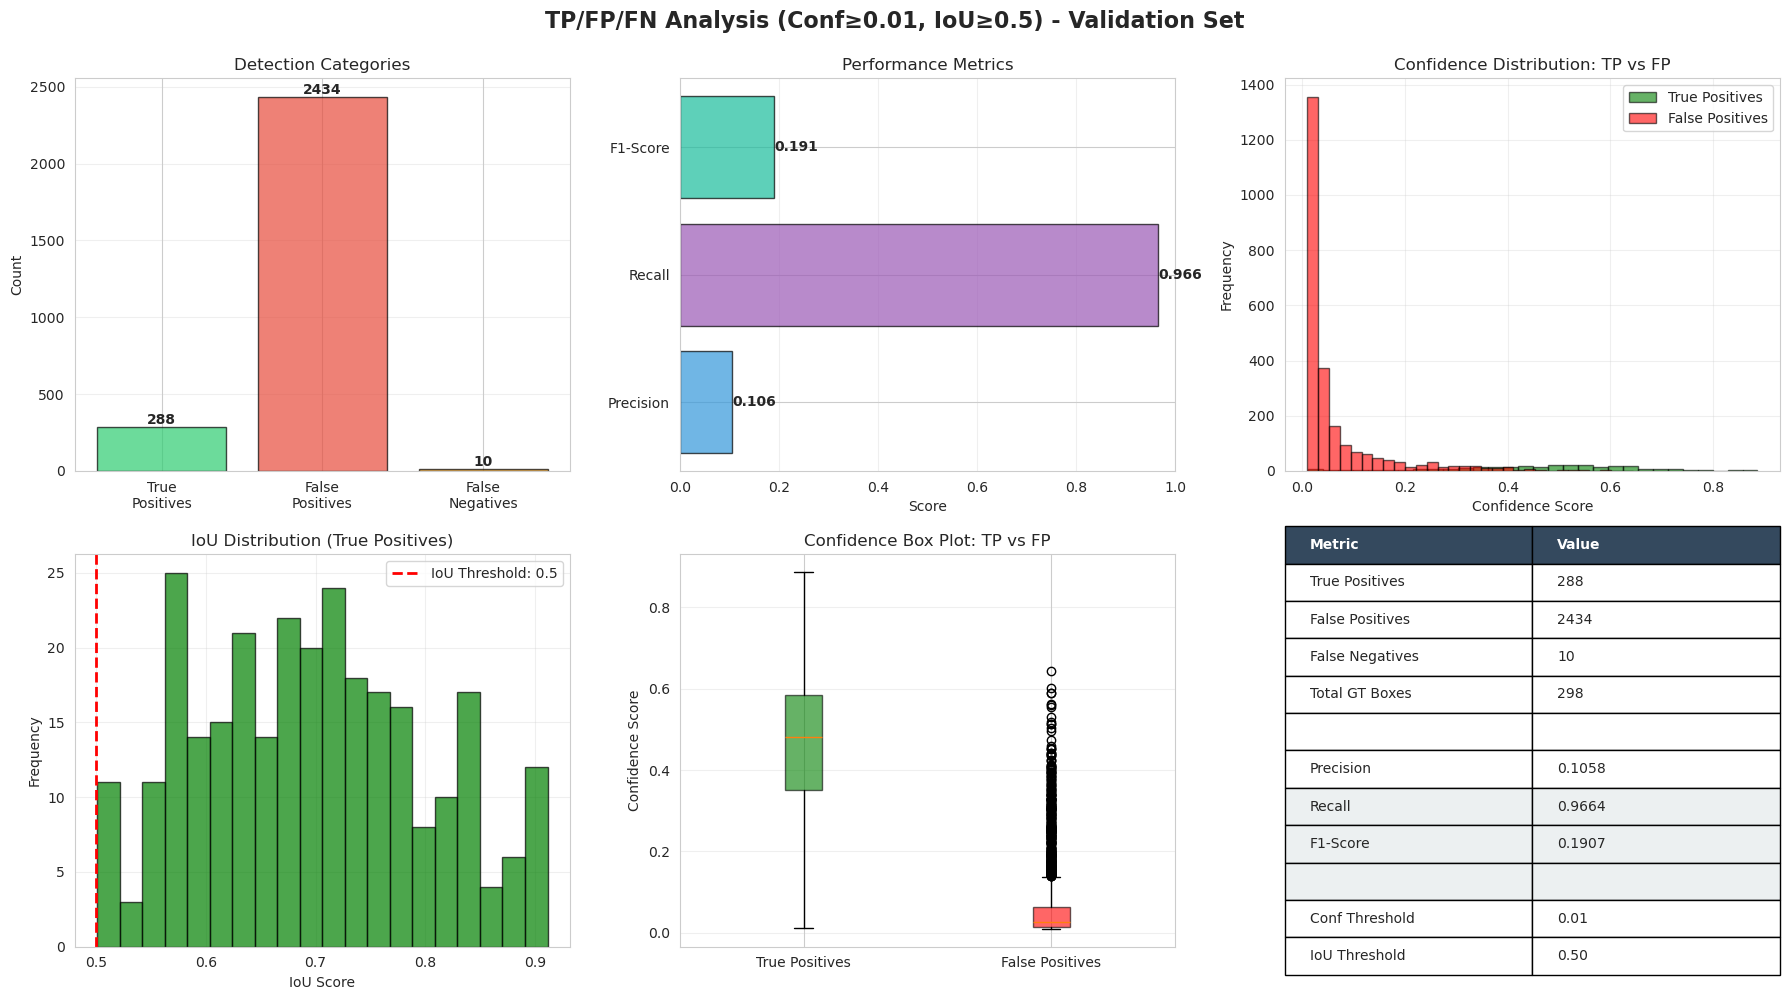


✓ Visualization saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_tp_fp_fn_analysis.png


In [11]:
# Configure paths for validation analysis
val_predictions_json = val_predictions_path
val_images_list = val_txt_file  # From cell earlier: validation images list

# Labels will be automatically inferred from image paths (replacing 'images' with 'labels')
# Verify paths exist
print(f"Predictions JSON: {val_predictions_json}")
print(f"Predictions exists: {val_predictions_json.exists()}")
print(f"\nImages list: {val_images_list}")
print(f"Images list exists: {Path(val_images_list).exists()}")
print(f"\nLabels will be auto-inferred from image paths (images -> labels)")

# Reload module to get updated functions
import importlib, sys
if 'detection_analysis' in sys.modules:
    del sys.modules['detection_analysis']
from detection_analysis import analyze_tp_fp_fn, visualize_tp_fp_fn_analysis

# Run TP/FP/FN analysis with single_class=True (model trained with single_class)
val_results = analyze_tp_fp_fn(
    predictions_json_path=val_predictions_json,
    images_list_path=val_images_list,
    iou_threshold=0.5,
    conf_threshold=0.01,
    single_class=True,  # Ignore class labels, match only by IoU
    verbose=True
)

# Save visualization
val_viz_path = RESULTS_DIR / "val_tp_fp_fn_analysis.png"
visualize_tp_fp_fn_analysis(val_results, val_viz_path, title_suffix="Validation Set")

### Precision-Recall vs Confidence Threshold
Sweep confidence thresholds to find the point where precision equals recall, and visualize precision/recall curves.


--- Precision vs Recall Equalization ---
Best confidence threshold: 0.330 (exact)
Precision: 0.7584
Recall:    0.7584
Abs diff:  0.0000


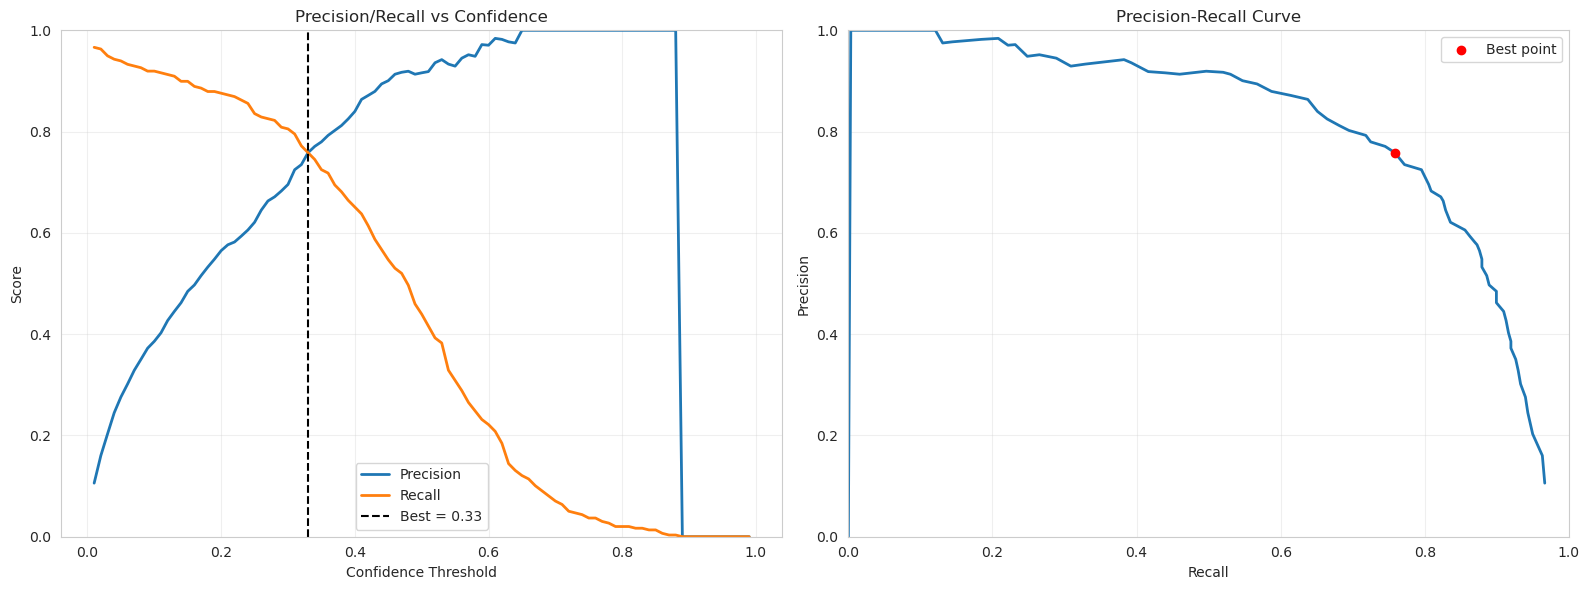

✓ Curves saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_precision_recall_vs_conf.png


In [16]:
# Sweep confidence thresholds on validation set
if not val_predictions_path.exists():
    print(f"✗ Predictions file not found: {val_predictions_path}")
else:
    iou_threshold = 0.5
    thresholds = np.linspace(0.01, 0.99, 99)
    precision_vals = []
    recall_vals = []
    valid_thresholds = []
    
    for conf in thresholds:
        res = analyze_tp_fp_fn(
            predictions_json_path=val_predictions_path,
            images_list_path=val_txt_file,
            iou_threshold=iou_threshold,
            conf_threshold=float(conf),
            single_class=True,
            verbose=False,
        )
        if res is None:
            continue
        precision = res.get("precision")
        recall = res.get("recall")
        if precision is None or recall is None:
            continue
        precision_vals.append(precision)
        recall_vals.append(recall)
        valid_thresholds.append(float(conf))
    
    if not valid_thresholds:
        print("✗ No valid precision/recall results. Check predictions or analysis inputs.")
    else:
        precision_vals = np.array(precision_vals)
        recall_vals = np.array(recall_vals)
        valid_thresholds = np.array(valid_thresholds)
        
        # Find the first meaningful crossing between precision and recall
        # Filter out points where both precision and recall are too low (< 0.1)
        diff = precision_vals - recall_vals
        meaningful_mask = (precision_vals > 0.1) & (recall_vals > 0.1)
        
        # Look for exact matches (where diff ≈ 0) only in meaningful range
        exact_idx = np.where(np.isclose(diff, 0.0, atol=1e-6) & meaningful_mask)[0]
        if exact_idx.size > 0:
            best_idx = int(exact_idx[0])
            best_conf = float(valid_thresholds[best_idx])
            best_precision = float(precision_vals[best_idx])
            best_recall = float(recall_vals[best_idx])
            selection_note = "exact"
        else:
            # Look for sign changes (crossings) only in meaningful range
            sign_changes = np.where((np.sign(diff[:-1]) != np.sign(diff[1:])) & meaningful_mask[:-1])[0]
            if sign_changes.size > 0:
                i = int(sign_changes[0])
                x0, x1 = valid_thresholds[i], valid_thresholds[i + 1]
                y0, y1 = diff[i], diff[i + 1]
                if y1 == y0:
                    best_conf = float(x0)
                    alpha = 0.0
                else:
                    best_conf = float(x0 - y0 * (x1 - x0) / (y1 - y0))
                    alpha = (best_conf - x0) / (x1 - x0) if x1 != x0 else 0.0
                best_precision = float(precision_vals[i] + alpha * (precision_vals[i + 1] - precision_vals[i]))
                best_recall = float(recall_vals[i] + alpha * (recall_vals[i + 1] - recall_vals[i]))
                best_idx = i
                selection_note = "first_crossing"
            else:
                # Fallback: find minimum difference in meaningful range
                meaningful_indices = np.where(meaningful_mask)[0]
                if meaningful_indices.size > 0:
                    diffs_meaningful = np.abs(diff[meaningful_indices])
                    best_idx_in_meaningful = int(np.argmin(diffs_meaningful))
                    best_idx = int(meaningful_indices[best_idx_in_meaningful])
                    best_conf = float(valid_thresholds[best_idx])
                    best_precision = float(precision_vals[best_idx])
                    best_recall = float(recall_vals[best_idx])
                    selection_note = "closest"
                else:
                    # Last resort: use overall minimum
                    diffs = np.abs(diff)
                    best_idx = int(np.argmin(diffs))
                    best_conf = float(valid_thresholds[best_idx])
                    best_precision = float(precision_vals[best_idx])
                    best_recall = float(recall_vals[best_idx])
                    selection_note = "closest"
        
        best_diff = abs(best_precision - best_recall)
        print("\n--- Precision vs Recall Equalization ---")
        print(f"Best confidence threshold: {best_conf:.3f} ({selection_note})")
        print(f"Precision: {best_precision:.4f}")
        print(f"Recall:    {best_recall:.4f}")
        print(f"Abs diff:  {best_diff:.4f}")
        
        # Plot precision and recall vs threshold
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        ax = axes[0]
        ax.plot(valid_thresholds, precision_vals, label="Precision", linewidth=2)
        ax.plot(valid_thresholds, recall_vals, label="Recall", linewidth=2)
        ax.axvline(best_conf, color="black", linestyle="--", label=f"Best = {best_conf:.2f}")
        ax.set_xlabel("Confidence Threshold")
        ax.set_ylabel("Score")
        ax.set_title("Precision/Recall vs Confidence")
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Precision-Recall curve
        ax = axes[1]
        ax.plot(recall_vals, precision_vals, linewidth=2)
        ax.scatter([best_recall], [best_precision], color="red", zorder=5, label="Best point")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("Precision-Recall Curve")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        pr_curve_path = RESULTS_DIR / "val_precision_recall_vs_conf.png"
        plt.savefig(pr_curve_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"✓ Curves saved to: {pr_curve_path}")

#


Predictions JSON: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_predictions.json
Predictions exists: True

Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/val/val_92.3-7.7.txt
Images list exists: True

Labels will be auto-inferred from image paths (images -> labels)

ANALYZING TP/FP/FN
  IoU threshold: 0.5
  Confidence threshold: 0.33
  Single class mode: True
  Predictions: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_predictions.json
  Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/val/val_92.3-7.7.txt
  Loaded 3265 image paths from list



--- Detection Analysis Summary ---
Images processed: 3265
Total ground truth boxes: 298

Detection Results:
  True Positives (TP):     226 - Correct detections
  False Positives (FP):     72 - Incorrect detections
  False Negatives (FN):     72 - Missed objects

--- Performance Metrics ---
  Precision: 0.7584 - 75.84% of detections are correct
  Recall:    0.7584 - 75.84% of objects are detected
  F1-Score:  0.7584 - Harmonic mean of Precision and Recall

--- True Positives Confidence ---
  Mean: 0.5339, Median: 0.5320
  Range: [0.3351, 0.8861]

--- False Positives Confidence ---
  Mean: 0.4187, Median: 0.4004
  Range: [0.3324, 0.6436]

--- True Positives IoU ---
  Mean: 0.7071, Median: 0.7072
  Range: [0.5010, 0.9115]


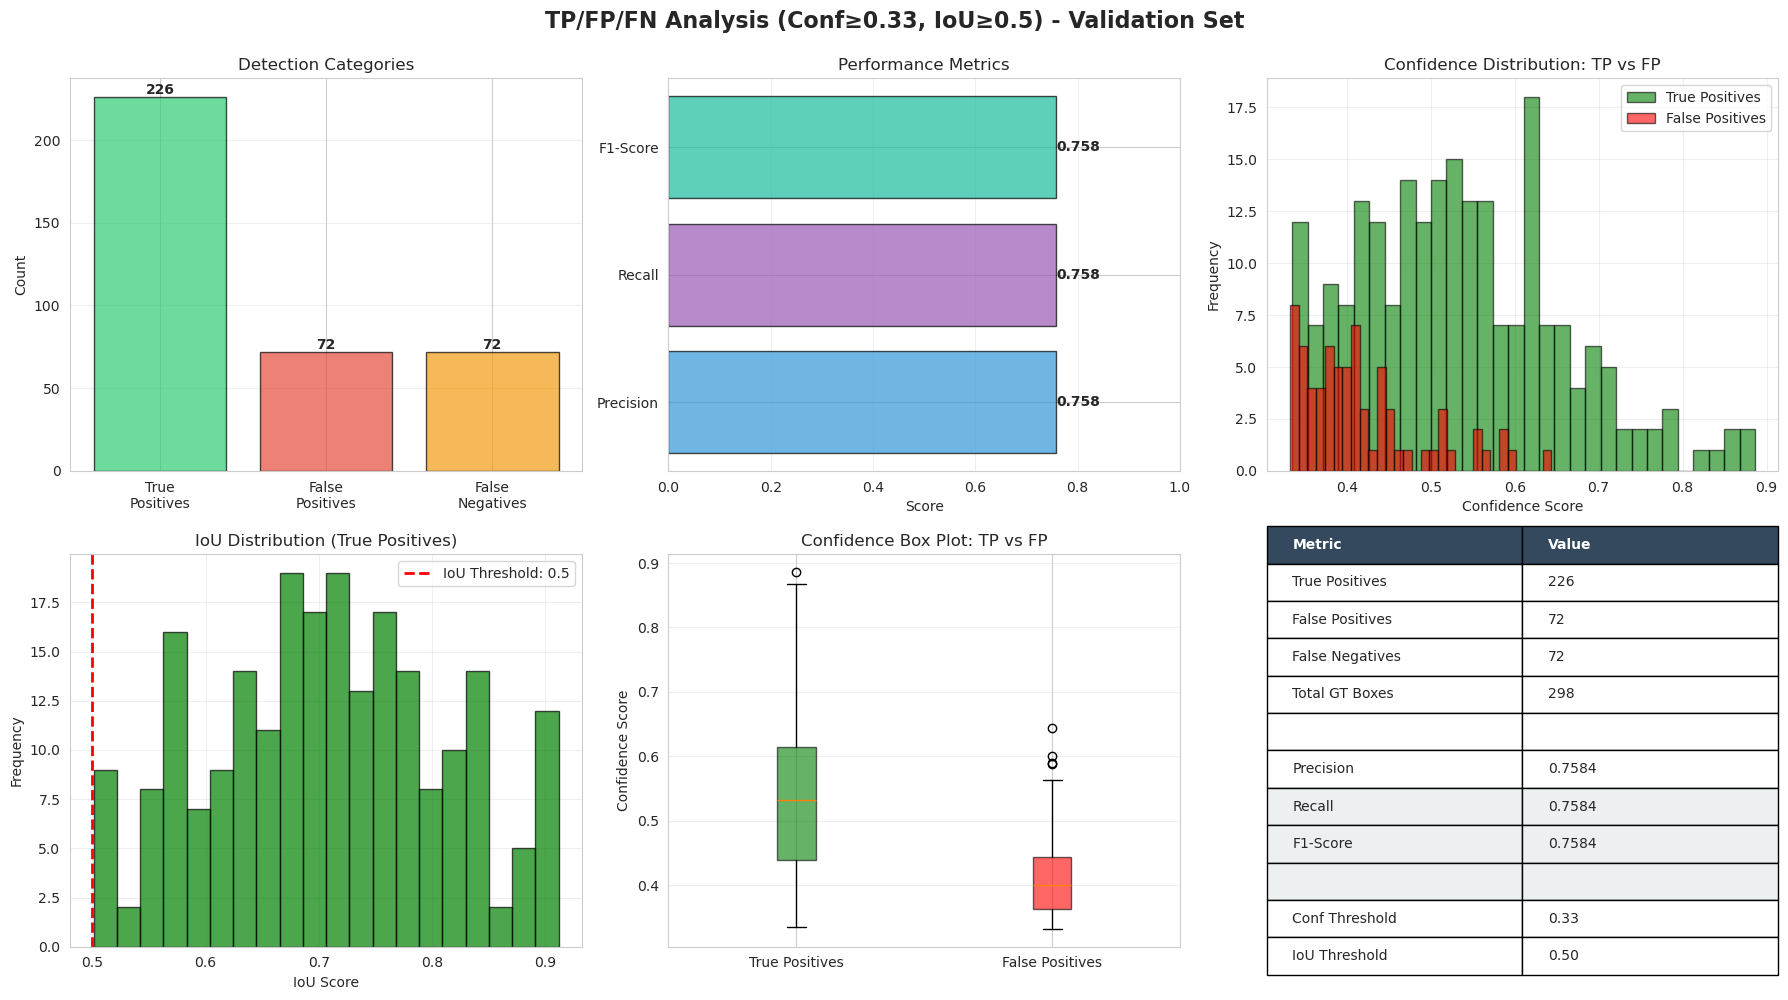


✓ Visualization saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/val_tp_fp_fn_analysis_0_33conf.png


In [13]:
# Configure paths for validation analysis
val_predictions_json = val_predictions_path
val_images_list = val_txt_file  # From cell earlier: validation images list

# Labels will be automatically inferred from image paths (replacing 'images' with 'labels')
# Verify paths exist
print(f"Predictions JSON: {val_predictions_json}")
print(f"Predictions exists: {val_predictions_json.exists()}")
print(f"\nImages list: {val_images_list}")
print(f"Images list exists: {Path(val_images_list).exists()}")
print(f"\nLabels will be auto-inferred from image paths (images -> labels)")

# Reload module to get updated functions
import importlib, sys
if 'detection_analysis' in sys.modules:
    del sys.modules['detection_analysis']
from detection_analysis import analyze_tp_fp_fn, visualize_tp_fp_fn_analysis

# Run TP/FP/FN analysis with single_class=True (model trained with single_class)
val_results = analyze_tp_fp_fn(
    predictions_json_path=val_predictions_json,
    images_list_path=val_images_list,
    iou_threshold=0.5,
    conf_threshold=0.33,
    single_class=True,  # Ignore class labels, match only by IoU
    verbose=True
)

# Save visualization
val_viz_path = RESULTS_DIR / "val_tp_fp_fn_analysis_0_33conf.png"
visualize_tp_fp_fn_analysis(val_results, val_viz_path, title_suffix="Validation Set")

### Test

Running evaluation on test set...
Processing predictions...


  Processed 500 images...
  Processed 1000 images...
  Processed 1500 images...
  Processed 2000 images...
  Processed 2500 images...
  Processed 3000 images...
Results saved to /home/detect/DeTect_TaiwanBirds_VideoDetector/deep_learning/runs/detect/predict17
Saved 3146 predictions to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_predictions.json
✓ Test predictions completed.
✓ Images processed: 3146
✓ Test predictions saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_predictions.json
✓ Validation predictions loaded: 3146 images

--- Statistics ---
Total images: 3146
Images with detections: 873
Images without detections: 2273
Total detections: 2236
Average detections per image: 0.71

--- Confidence Scores ---
Min: 0.0100
Max: 0.8806
Mean: 0.1019
Median: 0.0323
Std Dev: 0.1482


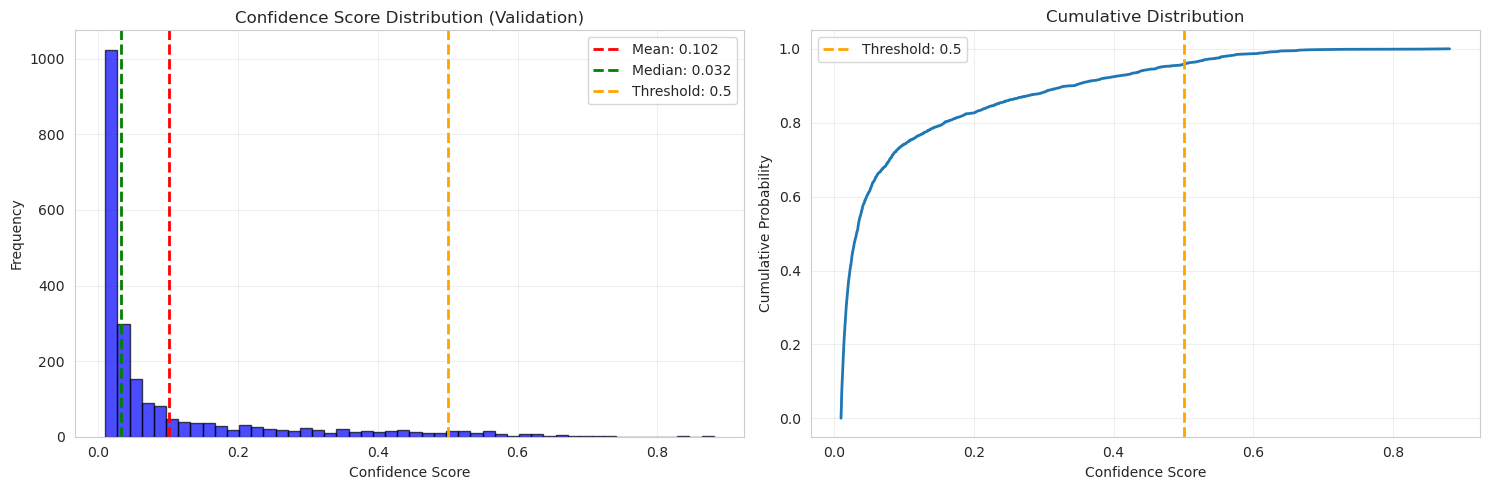

✓ Confidence distribution plots saved

--- Predictions by Confidence Range ---
0.00 - 0.25: 1923 predictions (86.0%)
0.25 - 0.50: 218 predictions (9.7%)
0.50 - 0.75: 92 predictions (4.1%)
0.75 - 1.00: 3 predictions (0.1%)


In [14]:
print("Running evaluation on test set...")
print("=" * 80)

test_txt_file = "/home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/test/test.txt"
test_predictions_path = RESULTS_DIR / "test_predictions.json"

test_pred_count = run_stream_predictions_to_json(
    model=model,
    source=test_txt_file,
    output_path=test_predictions_path,
    conf=0.01,
    imgsz=IMGSZ,
    batch=1,
    device="cuda",
    save=True,
    stream=True,
    verbose=False,
)

print("✓ Test predictions completed.")
print(f"✓ Images processed: {test_pred_count}")
print(f"✓ Test predictions saved to: {test_predictions_path}")

test_predictions = load_predictions_grouped(test_predictions_path)
if test_predictions:
    print(f"✓ Validation predictions loaded: {len(test_predictions)} images")

    basic_statistics(test_predictions)
else:
    print(f"✗ Predictions file not found: {test_predictions_path}")


--- Precision vs Recall Equalization ---
Best confidence threshold: 0.890 (exact)
Precision: 0.0000
Recall:    0.0000
Abs diff:  0.0000


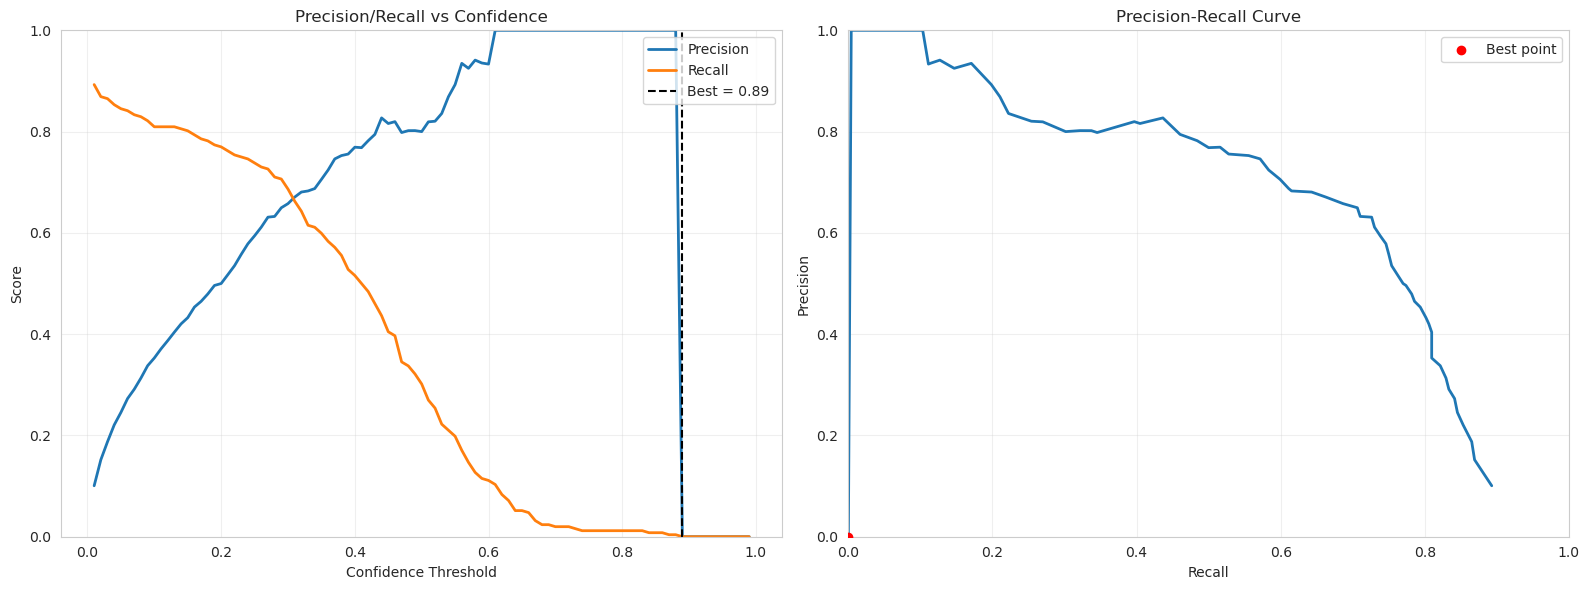

✓ Curves saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_precision_recall_vs_conf.png


In [ ]:
# Sweep confidence thresholds on test set
if not test_predictions_path.exists():
    print(f"✗ Predictions file not found: {test_predictions_path}")
else:
    iou_threshold = 0.5
    thresholds = np.linspace(0.01, 0.99, 99)
    precision_test = []
    recall_test = []
    valid_thresholds = []
    
    for conf in thresholds:
        res = analyze_tp_fp_fn(
            predictions_json_path=test_predictions_path,
            images_list_path=test_txt_file,
            iou_threshold=iou_threshold,
            conf_threshold=float(conf),
            single_class=True,
            verbose=False,
        )
        if res is None:
            continue
        precision = res.get("precision")
        recall = res.get("recall")
        if precision is None or recall is None:
            continue
        precision_test.append(precision)
        recall_test.append(recall)
        valid_thresholds.append(float(conf))
    
    if not valid_thresholds:
        print("✗ No valid precision/recall results. Check predictions or analysis inputs.")
    else:
        precision_test = np.array(precision_test)
        recall_test = np.array(recall_test)
        valid_thresholds = np.array(valid_thresholds)
        
        # Find the first meaningful crossing between precision and recall
        # Filter out points where both precision and recall are too low (< 0.1)
        diff = precision_test - recall_test
        meaningful_mask = (precision_test > 0.1) & (recall_test > 0.1)
        
        # Look for exact matches (where diff ≈ 0) only in meaningful range
        exact_idx = np.where(np.isclose(diff, 0.0, atol=1e-6) & meaningful_mask)[0]
        if exact_idx.size > 0:
            best_idx = int(exact_idx[0])
            best_conf = float(valid_thresholds[best_idx])
            best_precision = float(precision_test[best_idx])
            best_recall = float(recall_test[best_idx])
            selection_note = "exact"
        else:
            # Look for sign changes (crossings) only in meaningful range
            sign_changes = np.where((np.sign(diff[:-1]) != np.sign(diff[1:])) & meaningful_mask[:-1])[0]
            if sign_changes.size > 0:
                i = int(sign_changes[0])
                x0, x1 = valid_thresholds[i], valid_thresholds[i + 1]
                y0, y1 = diff[i], diff[i + 1]
                if y1 == y0:
                    best_conf = float(x0)
                    alpha = 0.0
                else:
                    best_conf = float(x0 - y0 * (x1 - x0) / (y1 - y0))
                    alpha = (best_conf - x0) / (x1 - x0) if x1 != x0 else 0.0
                best_precision = float(precision_test[i] + alpha * (precision_test[i + 1] - precision_test[i]))
                best_recall = float(recall_test[i] + alpha * (recall_test[i + 1] - recall_test[i]))
                best_idx = i
                selection_note = "first_crossing"
            else:
                # Fallback: find minimum difference in meaningful range
                meaningful_indices = np.where(meaningful_mask)[0]
                if meaningful_indices.size > 0:
                    diffs_meaningful = np.abs(diff[meaningful_indices])
                    best_idx_in_meaningful = int(np.argmin(diffs_meaningful))
                    best_idx = int(meaningful_indices[best_idx_in_meaningful])
                    best_conf = float(valid_thresholds[best_idx])
                    best_precision = float(precision_test[best_idx])
                    best_recall = float(recall_test[best_idx])
                    selection_note = "closest"
                else:
                    # Last resort: use overall minimum
                    diffs = np.abs(diff)
                    best_idx = int(np.argmin(diffs))
                    best_conf = float(valid_thresholds[best_idx])
                    best_precision = float(precision_test[best_idx])
                    best_recall = float(recall_test[best_idx])
                    selection_note = "closest"
        
        best_diff = abs(best_precision - best_recall)
        print("\n--- Precision vs Recall Equalization ---")
        print(f"Best confidence threshold: {best_conf:.3f} ({selection_note})")
        print(f"Precision: {best_precision:.4f}")
        print(f"Recall:    {best_recall:.4f}")
        print(f"Abs diff:  {best_diff:.4f}")
        
        # Plot precision and recall vs threshold
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        ax = axes[0]
        ax.plot(valid_thresholds, precision_test, label="Precision", linewidth=2)
        ax.plot(valid_thresholds, recall_test, label="Recall", linewidth=2)
        ax.axvline(best_conf, color="black", linestyle="--", label=f"Best = {best_conf:.2f}")
        ax.set_xlabel("Confidence Threshold")
        ax.set_ylabel("Score")
        ax.set_title("Precision/Recall vs Confidence")
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Precision-Recall curve
        ax = axes[1]
        ax.plot(recall_test, precision_test, linewidth=2)
        ax.scatter([best_recall], [best_precision], color="red", zorder=5, label="Best point")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("Precision-Recall Curve")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        plt.tight_layout()
        pr_curve_path = RESULTS_DIR / "test_precision_recall_vs_conf.png"
        plt.savefig(pr_curve_path, dpi=150, bbox_inches="tight")
        plt.show()
        print(f"✓ Curves saved to: {pr_curve_path}")

Predictions JSON: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_predictions.json
Predictions exists: True

Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/test/test.txt
Images list exists: True

Labels will be auto-inferred from image paths (images -> labels)

ANALYZING TP/FP/FN
  IoU threshold: 0.5
  Confidence threshold: 0.01
  Single class mode: True
  Predictions: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_predictions.json
  Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/test/test.txt
  Loaded 3146 image paths from list

--- Detection Analysis Summary ---
Images processed: 3146
Total ground truth boxes: 252

Detection Results:
  True Positives (TP):     225 - Correct detections
  False Positives (FP):   2011 - Incorrect detections
  False Negatives (FN):     27 - Missed objects

--- Performance Metrics ---
  Precision: 0.1006 - 10.06% of detections are correct
  Recall:    0.89

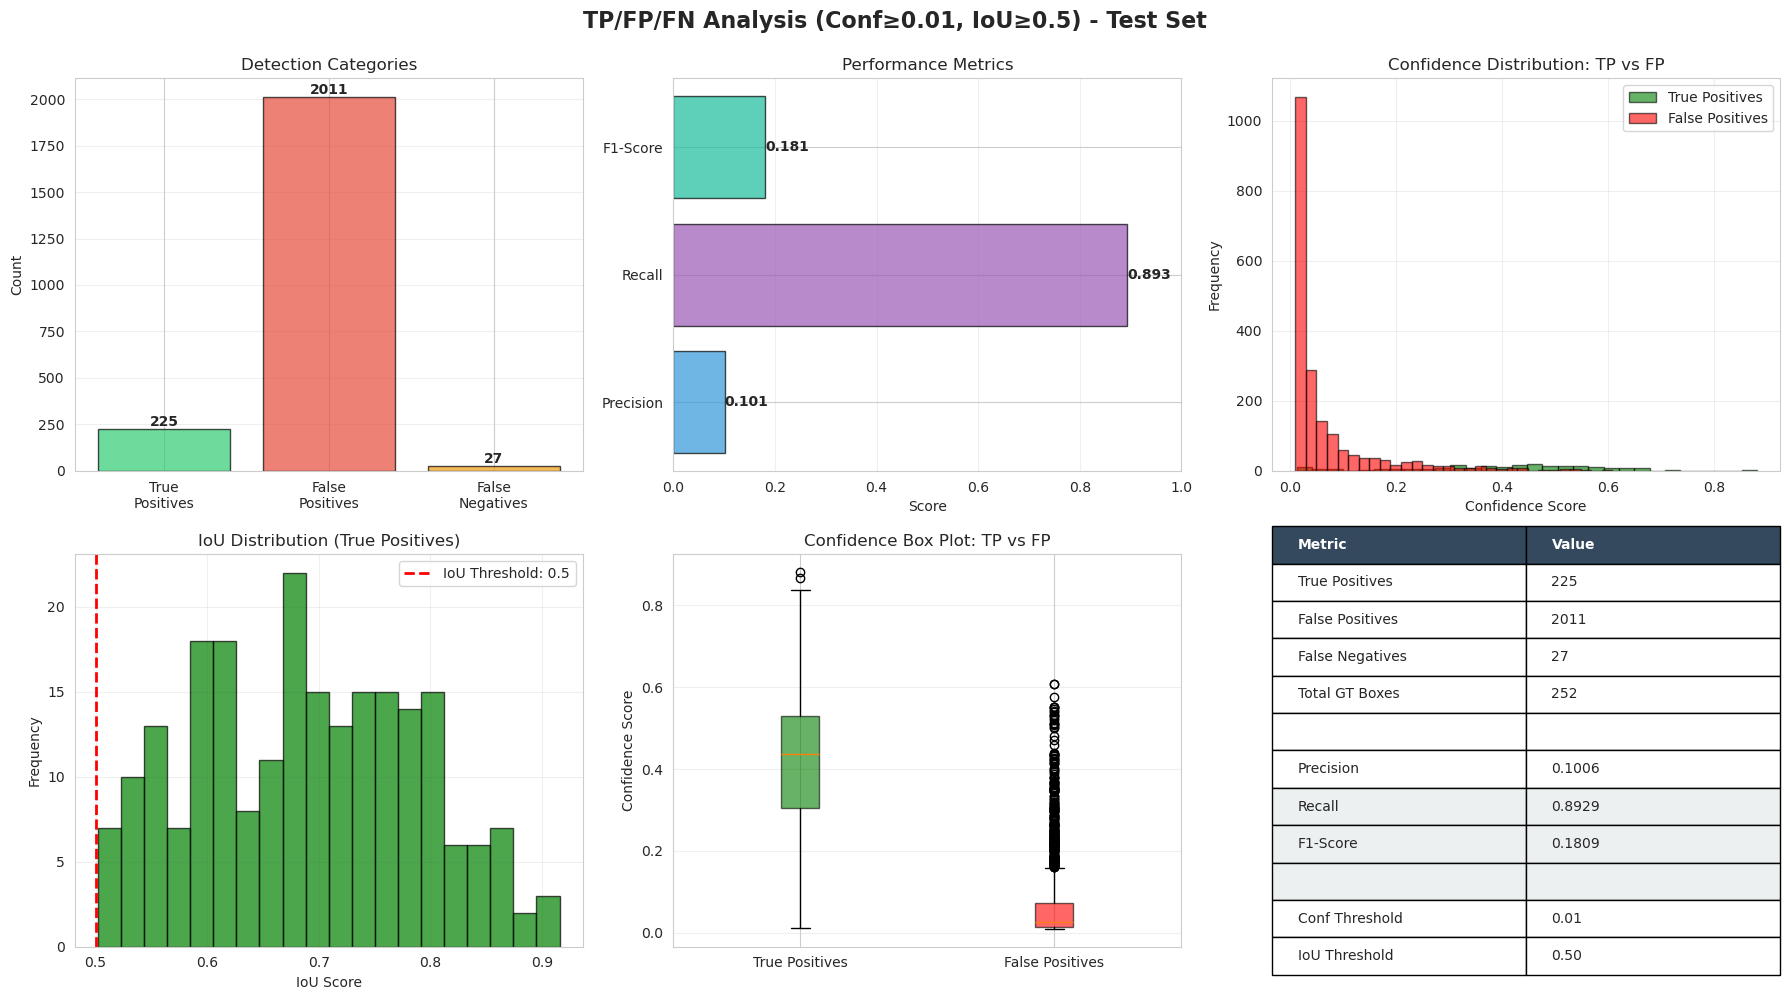


✓ Visualization saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_tp_fp_fn_analysis.png


In [15]:
# Configure paths for test analysis
test_predictions_json = test_predictions_path
test_images_list = test_txt_file  # From cell earlier: test images list

# Labels will be automatically inferred from image paths (replacing 'images' with 'labels')
# Verify paths exist
print(f"Predictions JSON: {test_predictions_json}")
print(f"Predictions exists: {test_predictions_json.exists()}")
print(f"\nImages list: {test_images_list}")
print(f"Images list exists: {Path(test_images_list).exists()}")
print(f"\nLabels will be auto-inferred from image paths (images -> labels)")

# Run TP/FP/FN analysis with single_class=True (model trained with single_class)
test_results = analyze_tp_fp_fn(
    predictions_json_path=test_predictions_json,
    images_list_path=test_images_list,
    iou_threshold=0.5,
    conf_threshold=0.01,
    single_class=True,  # Ignore class labels, match only by IoU
    verbose=True
)

# Save visualization
test_viz_path = RESULTS_DIR / "test_tp_fp_fn_analysis.png"
visualize_tp_fp_fn_analysis(test_results, test_viz_path, title_suffix="Test Set")

Predictions JSON: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_predictions.json
Predictions exists: True

Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/test/test.txt
Images list exists: True

Labels will be auto-inferred from image paths (images -> labels)

ANALYZING TP/FP/FN
  IoU threshold: 0.5
  Confidence threshold: 0.244
  Single class mode: True
  Predictions: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_predictions.json
  Images list: /home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/csvs/split_ratios/test/test.txt
  Loaded 3146 image paths from list



--- Detection Analysis Summary ---
Images processed: 3146
Total ground truth boxes: 252

Detection Results:
  True Positives (TP):     187 - Correct detections
  False Positives (FP):    132 - Incorrect detections
  False Negatives (FN):     65 - Missed objects

--- Performance Metrics ---
  Precision: 0.5862 - 58.62% of detections are correct
  Recall:    0.7421 - 74.21% of objects are detected
  F1-Score:  0.6550 - Harmonic mean of Precision and Recall

--- True Positives Confidence ---
  Mean: 0.4700, Median: 0.4633
  Range: [0.2448, 0.8806]

--- False Positives Confidence ---
  Mean: 0.3627, Median: 0.3466
  Range: [0.2449, 0.6081]

--- True Positives IoU ---
  Mean: 0.7012, Median: 0.7006
  Range: [0.5027, 0.9156]


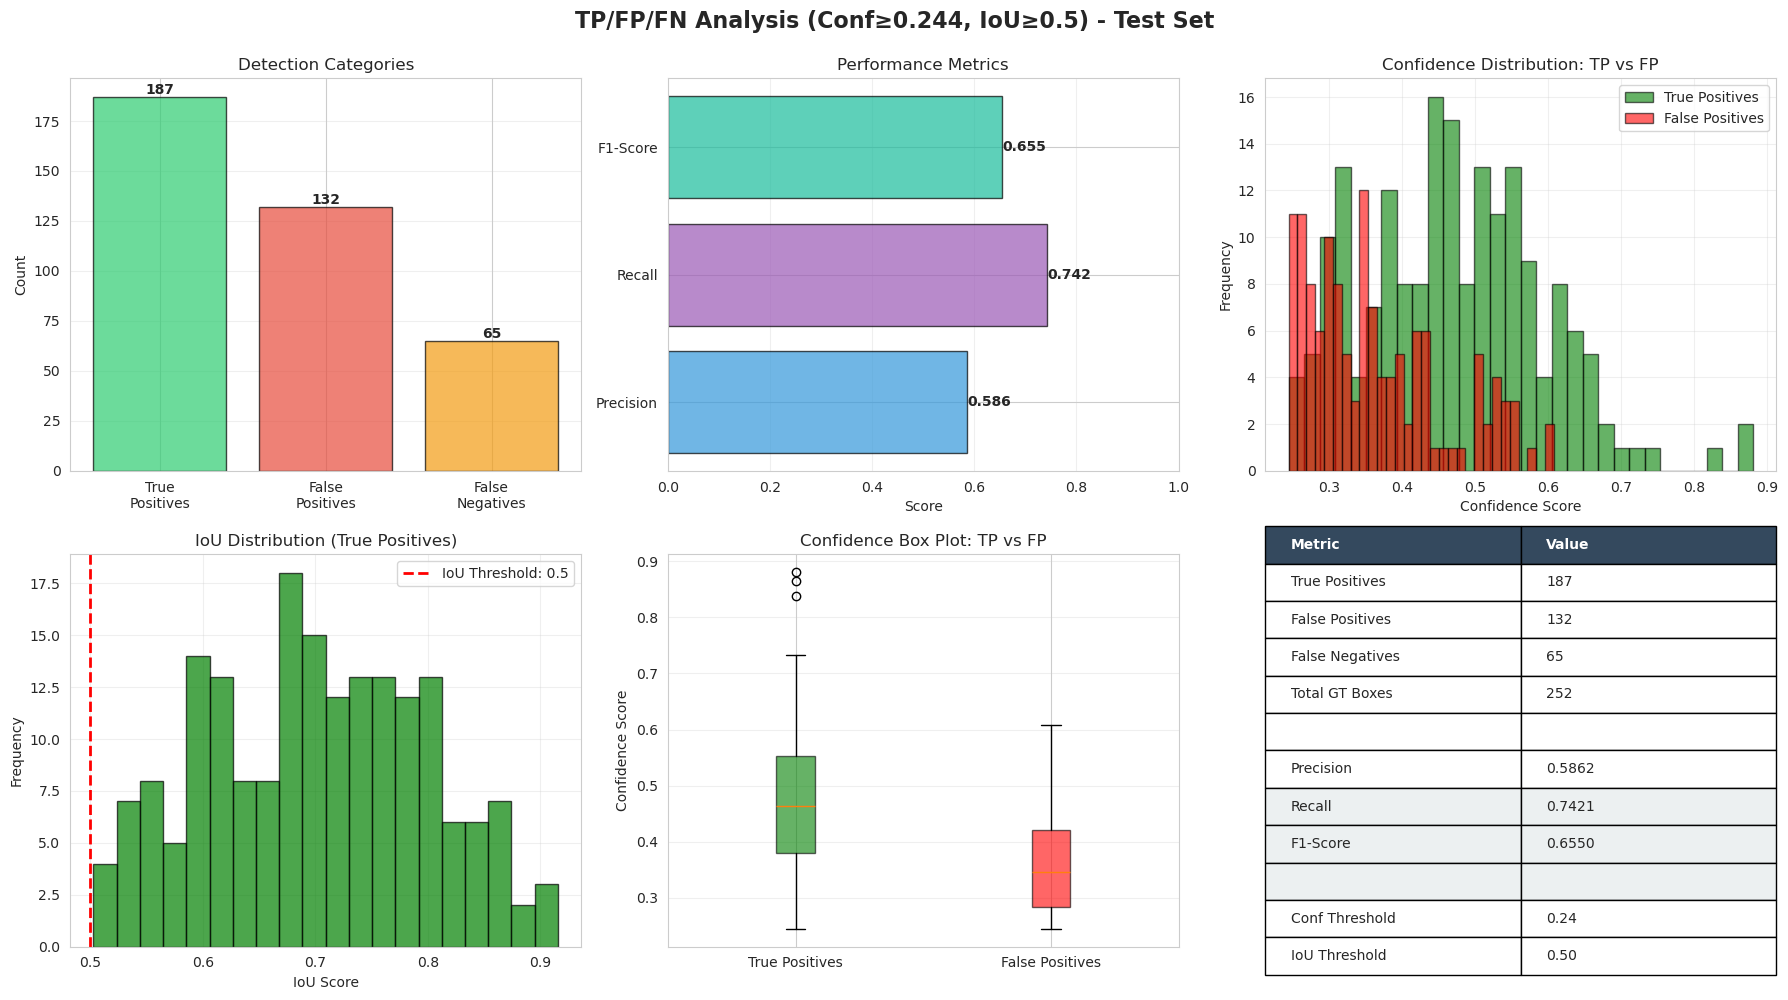


✓ Visualization saved to: DeTect-BMMS/runs/yolov26m-default-imgz1280_DeTect20002/test_tp_fp_fn_analysis_0_244.png


In [16]:
# Configure paths for test analysis
test_predictions_json = test_predictions_path
test_images_list = test_txt_file  # From cell earlier: test images list

# Labels will be automatically inferred from image paths (replacing 'images' with 'labels')
# Verify paths exist
print(f"Predictions JSON: {test_predictions_json}")
print(f"Predictions exists: {test_predictions_json.exists()}")
print(f"\nImages list: {test_images_list}")
print(f"Images list exists: {Path(test_images_list).exists()}")
print(f"\nLabels will be auto-inferred from image paths (images -> labels)")

# Run TP/FP/FN analysis with single_class=True (model trained with single_class)
test_results = analyze_tp_fp_fn(
    predictions_json_path=test_predictions_json,
    images_list_path=test_images_list,
    iou_threshold=0.5,
    conf_threshold=0.244,
    single_class=True,  # Ignore class labels, match only by IoU
    verbose=True
)

# Save visualization
test_viz_path = RESULTS_DIR / "test_tp_fp_fn_analysis_0_244.png"
visualize_tp_fp_fn_analysis(test_results, test_viz_path, title_suffix="Test Set")

In [17]:
# Compare Validation vs Test performance
print("\n" + "="*80)
print("VALIDATION vs TEST: Performance Comparison")
print("="*80)

# Choose a specific confidence threshold for detailed comparison
comparison_conf = 0.5

val_res = val_analysis_results[comparison_conf]
test_res = test_analysis_results[comparison_conf]

comparison_table = [
    ['Metric', 'Validation', 'Test', 'Difference'],
    ['True Positives', f"{val_res['n_tp']}", f"{test_res['n_tp']}", f"{test_res['n_tp'] - val_res['n_tp']:+d}"],
    ['False Positives', f"{val_res['n_fp']}", f"{test_res['n_fp']}", f"{test_res['n_fp'] - val_res['n_fp']:+d}"],
    ['False Negatives', f"{val_res['n_fn']}", f"{test_res['n_fn']}", f"{test_res['n_fn'] - val_res['n_fn']:+d}"],
    ['Precision', f"{val_res['precision']:.4f}", f"{test_res['precision']:.4f}", f"{test_res['precision'] - val_res['precision']:+.4f}"],
    ['Recall', f"{val_res['recall']:.4f}", f"{test_res['recall']:.4f}", f"{test_res['recall'] - val_res['recall']:+.4f}"],
    ['F1-Score', f"{val_res['f1_score']:.4f}", f"{test_res['f1_score']:.4f}", f"{test_res['f1_score'] - val_res['f1_score']:+.4f}"],
]

print(f"\nComparison at Confidence Threshold = {comparison_conf}")
print("-" * 80)
for row in comparison_table:
    print(f"{row[0]:<20} {row[1]:<15} {row[2]:<15} {row[3]:<15}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: TP/FP/FN comparison
ax = axes[0, 0]
categories = ['TP', 'FP', 'FN']
val_counts = [val_res['n_tp'], val_res['n_fp'], val_res['n_fn']]
test_counts = [test_res['n_tp'], test_res['n_fp'], test_res['n_fn']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, val_counts, width, label='Validation', alpha=0.7)
bars2 = ax.bar(x + width/2, test_counts, width, label='Test', alpha=0.7)

ax.set_ylabel('Count')
ax.set_title('TP/FP/FN: Validation vs Test')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add count labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Precision, Recall, F1 comparison
ax = axes[0, 1]
metrics = ['Precision', 'Recall', 'F1-Score']
val_metrics = [val_res['precision'], val_res['recall'], val_res['f1_score']]
test_metrics = [test_res['precision'], test_res['recall'], test_res['f1_score']]

x = np.arange(len(metrics))
bars1 = ax.barh(x + width/2, val_metrics, width, label='Validation', alpha=0.7)
bars2 = ax.barh(x - width/2, test_metrics, width, label='Test', alpha=0.7)

ax.set_xlabel('Score')
ax.set_xlim([0, 1])
ax.set_title('Metrics: Validation vs Test')
ax.set_yticks(x)
ax.set_yticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        width_val = bar.get_width()
        ax.text(width_val, bar.get_y() + bar.get_height()/2.,
                f'{width_val:.3f}',
                ha='left', va='center', fontsize=9)

# Plot 3: Confidence distribution comparison (TP)
ax = axes[1, 0]
if val_res['true_positives'] and test_res['true_positives']:
    val_tp_confs = [tp['confidence'] for tp in val_res['true_positives']]
    test_tp_confs = [tp['confidence'] for tp in test_res['true_positives']]
    
    ax.hist(val_tp_confs, bins=30, alpha=0.6, label='Validation TP', color='blue', edgecolor='black')
    ax.hist(test_tp_confs, bins=30, alpha=0.6, label='Test TP', color='green', edgecolor='black')
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Frequency')
    ax.set_title('True Positives Confidence: Val vs Test')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot 4: Confidence distribution comparison (FP)
ax = axes[1, 1]
if val_res['false_positives'] and test_res['false_positives']:
    val_fp_confs = [fp['confidence'] for fp in val_res['false_positives']]
    test_fp_confs = [fp['confidence'] for fp in test_res['false_positives']]
    
    ax.hist(val_fp_confs, bins=30, alpha=0.6, label='Validation FP', color='orange', edgecolor='black')
    ax.hist(test_fp_confs, bins=30, alpha=0.6, label='Test FP', color='red', edgecolor='black')
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Frequency')
    ax.set_title('False Positives Confidence: Val vs Test')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Validation vs Test Comparison (Conf={comparison_conf}, IoU={iou_threshold})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'val_vs_test_tp_fp_fn_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Val vs Test comparison saved")

# Final interpretation
print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)
print("""
📊 Key Insights to Look For:

1. **Precision**: High precision means few false alarms
   - If test precision << val precision: Model may be overfitting
   
2. **Recall**: High recall means model catches most objects
   - If test recall << val recall: Model struggles to generalize
   
3. **F1-Score**: Best overall measure (balance of precision & recall)
   - Significant drop from val to test indicates generalization issues
   
4. **TP Confidence**: True Positives should have high confidence
   - Low TP confidence → Model is uncertain even when correct
   
5. **FP Confidence**: False Positives should have lower confidence than TP
   - High FP confidence → Model is confidently wrong (problematic)
   
6. **False Negatives**: Objects the model missed
   - High FN count → Consider lowering confidence threshold or more training

📈 Actions Based on Results:
   - High FP → Increase confidence threshold
   - High FN → Decrease confidence threshold or improve training
   - Low Precision → Model generates too many false detections
   - Low Recall → Model misses too many objects
""")


VALIDATION vs TEST: Performance Comparison


NameError: name 'val_analysis_results' is not defined

### Val vs Test Comparison

In [ ]:
# Define path to test labels
test_labels_dir = Path("/home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/labels/test")

# Check if labels directory exists
if not test_labels_dir.exists():
    print(f"⚠ Warning: Labels directory not found: {test_labels_dir}")
    print("Please update the path to your test labels directory")
    # Try alternative common paths
    alternative_paths = [
        Path("/home/detect/DeTect_TaiwanBirds_VideoDetector/dataset/test/labels"),
        Path("/home/detect/DeTect_TaiwanBirds_VideoDetector/DeTect-BMMS/data/labels/test"),
    ]
    for alt_path in alternative_paths:
        if alt_path.exists():
            test_labels_dir = alt_path
            print(f"✓ Found labels at: {test_labels_dir}")
            break
else:
    print(f"✓ Labels directory found: {test_labels_dir}")

# Run TP/FP/FN analysis for test set
test_analysis_results = {}

for conf_thresh in confidence_thresholds:
    print(f"\n{'#'*80}")
    print(f"# Running TEST analysis with confidence threshold = {conf_thresh}")
    print(f"{'#'*80}")
    
    results = analyze_tp_fp_fn(
        predictions_json_path=test_predictions_path,
        labels_dir=test_labels_dir,
        iou_threshold=iou_threshold,
        conf_threshold=conf_thresh
    )
    
    test_analysis_results[conf_thresh] = results
    
    # Visualize results
    save_path = RESULTS_DIR / f'test_tp_fp_fn_analysis_conf{conf_thresh:.2f}.png'
    visualize_tp_fp_fn_analysis(results, save_path)

### TP/FP/FN Analysis - Test

## 13. Comparación Val vs Test - Confidence Scores

In [ ]:
if all_confidences and test_confidences:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histograma comparativo
    ax = axes[0, 0]
    ax.hist(all_confidences, bins=50, alpha=0.5, label='Validation', color='blue', edgecolor='black')
    ax.hist(test_confidences, bins=50, alpha=0.5, label='Test', color='red', edgecolor='black')
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribución de Confidence Scores: Val vs Test')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Box plot
    ax = axes[0, 1]
    ax.boxplot([all_confidences, test_confidences], labels=['Validation', 'Test'])
    ax.set_ylabel('Confidence Score')
    ax.set_title('Box Plot: Distribución de Confidence')
    ax.grid(True, alpha=0.3)
    
    # Violin plot
    ax = axes[1, 0]
    parts = ax.violinplot([all_confidences, test_confidences], positions=[1, 2], showmeans=True, showmedians=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Validation', 'Test'])
    ax.set_ylabel('Confidence Score')
    ax.set_title('Violin Plot: Distribución de Confidence')
    ax.grid(True, alpha=0.3)
    
    # CDF comparativo
    ax = axes[1, 1]
    sorted_val = np.sort(all_confidences)
    sorted_test = np.sort(test_confidences)
    cumulative_val = np.arange(1, len(sorted_val) + 1) / len(sorted_val)
    cumulative_test = np.arange(1, len(sorted_test) + 1) / len(sorted_test)
    ax.plot(sorted_val, cumulative_val, linewidth=2, label='Validation')
    ax.plot(sorted_test, cumulative_test, linewidth=2, label='Test')
    ax.set_xlabel('Confidence Score')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('CDF Comparativa')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'val_vs_test_confidence.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Gráficas comparativas guardadas")
    
    # Comparación estadística
    print("\n--- Comparación Estadística Val vs Test ---")
    print(f"{'Métrica':<20} {'Validación':<15} {'Test':<15} {'Diferencia':<15}")
    print("-" * 65)
    print(f"{'Mean':<20} {np.mean(all_confidences):<15.4f} {np.mean(test_confidences):<15.4f} {abs(np.mean(all_confidences) - np.mean(test_confidences)):<15.4f}")
    print(f"{'Median':<20} {np.median(all_confidences):<15.4f} {np.median(test_confidences):<15.4f} {abs(np.median(all_confidences) - np.median(test_confidences)):<15.4f}")
    print(f"{'Std Dev':<20} {np.std(all_confidences):<15.4f} {np.std(test_confidences):<15.4f} {abs(np.std(all_confidences) - np.std(test_confidences)):<15.4f}")
    print(f"{'Min':<20} {min(all_confidences):<15.4f} {min(test_confidences):<15.4f}")
    print(f"{'Max':<20} {max(all_confidences):<15.4f} {max(test_confidences):<15.4f}")

## 14. Predicciones por Rango de Confianza - Análisis Detallado

In [ ]:
# Crear tabla detallada de análisis por rango de confianza
confidence_ranges = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), 
                     (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

data_by_range = []

for low, high in confidence_ranges:
    val_count = sum(1 for c in all_confidences if low <= c < high)
    test_count = sum(1 for c in test_confidences if low <= c < high)
    
    val_pct = (val_count / len(all_confidences) * 100) if all_confidences else 0
    test_pct = (test_count / len(test_confidences) * 100) if test_confidences else 0
    
    data_by_range.append({
        'Range': f'{low:.1f} - {high:.1f}',
        'Val Count': val_count,
        'Val %': f'{val_pct:.1f}%',
        'Test Count': test_count,
        'Test %': f'{test_pct:.1f}%'
    })

df_ranges = pd.DataFrame(data_by_range)
print("\n--- Análisis por Rango de Confianza ---")
print(df_ranges.to_string(index=False))

# Visualizar tabla
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = []
table_data.append(['Range', 'Val Count', 'Val %', 'Test Count', 'Test %'])
for _, row in df_ranges.iterrows():
    table_data.append([row['Range'], row['Val Count'], row['Val %'], row['Test Count'], row['Test %']])

table = ax.table(cellText=table_data, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Colorear encabezado
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Predicciones por Rango de Confianza', fontsize=14, fontweight='bold', pad=20)
plt.savefig(RESULTS_DIR / 'confidence_ranges_table.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Tabla de rangos guardada")

## 15. Análisis de Imágenes Sin Detecciones

In [ ]:
# Analizar imágenes sin detecciones
images_no_det_val = [img_name for img_name, preds in val_predictions.items() if not preds]
images_no_det_test = [img_name for img_name, preds in test_predictions.items() if not preds]

print("--- Análisis de Imágenes Sin Detecciones ---")
print(f"\nValidación:")
print(f"  Total de imágenes sin detecciones: {len(images_no_det_val)}")
if images_no_det_val:
    print(f"  Primeras 10 imágenes sin detecciones:")
    for i, img_name in enumerate(images_no_det_val[:10], 1):
        print(f"    {i}. {img_name}")

print(f"\nTest:")
print(f"  Total de imágenes sin detecciones: {len(images_no_det_test)}")
if images_no_det_test:
    print(f"  Primeras 10 imágenes sin detecciones:")
    for i, img_name in enumerate(images_no_det_test[:10], 1):
        print(f"    {i}. {img_name}")

# Visualizar imágenes sin detecciones
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Muestras de Imágenes Sin Detecciones (Validación)', fontsize=16, fontweight='bold')

for idx, (ax, img_name) in enumerate(zip(axes.flat, images_no_det_val[:10])):
    try:
        # Buscar imagen en carpetas de validación
        from pathlib import Path
        img_path = None
        for potential_path in [
            Path('../dataset') / 'images' / 'val' / img_name,
            Path('../dataset') / 'images' / 'val' / f'{img_name}.jpg',
            Path('../dataset') / 'images' / 'val' / f'{img_name}.png',
        ]:
            if potential_path.exists():
                img_path = potential_path
                break
        
        if img_path and img_path.exists():
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(f'{img_name}', fontsize=8)
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, f'Imagen no encontrada:\n{img_name}', 
                   ha='center', va='center', fontsize=8)
            ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error cargando imagen', ha='center', va='center', fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'images_no_detections_val.png', dpi=100, bbox_inches='tight')
plt.show()
print("\n✓ Visualización de imágenes sin detecciones guardada")

## 16. Imágenes con Más Detecciones

In [ ]:
# Encontrar imágenes con más detecciones
val_det_counts = [(img_name, len(preds)) for img_name, preds in val_predictions.items()]
val_det_counts.sort(key=lambda x: x[1], reverse=True)

test_det_counts = [(img_name, len(preds)) for img_name, preds in test_predictions.items()]
test_det_counts.sort(key=lambda x: x[1], reverse=True)

print("--- Imágenes con Más Detecciones ---")
print(f"\nValidación (Top 15):")
for i, (img_name, count) in enumerate(val_det_counts[:15], 1):
    print(f"  {i:2d}. {img_name:<50} {count:3d} detecciones")

print(f"\nTest (Top 15):")
for i, (img_name, count) in enumerate(test_det_counts[:15], 1):
    print(f"  {i:2d}. {img_name:<50} {count:3d} detecciones")

# Gráficas de distribución de detecciones por imagen
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Validación
val_counts_only = [count for _, count in val_det_counts]
ax = axes[0]
ax.hist(val_counts_only, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Número de Detecciones por Imagen')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Detecciones por Imagen (Validación)')
ax.grid(True, alpha=0.3)
ax.axvline(np.mean(val_counts_only), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(val_counts_only):.2f}')
ax.legend()

# Test
test_counts_only = [count for _, count in test_det_counts]
ax = axes[1]
ax.hist(test_counts_only, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax.set_xlabel('Número de Detecciones por Imagen')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Detecciones por Imagen (Test)')
ax.grid(True, alpha=0.3)
ax.axvline(np.mean(test_counts_only), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_counts_only):.2f}')
ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'detection_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Gráficas de distribución de detecciones guardadas")

## 17. Análisis de Bounding Boxes - Tamaños y Posiciones

In [ ]:
# Analizar tamaños y posiciones de bounding boxes
bbox_areas = []
bbox_widths = []
bbox_heights = []
bbox_positions = []  # Centro del bbox
confidence_by_size = {'small': [], 'medium': [], 'large': []}

for img_name, preds in val_predictions.items():
    for pred in preds:
        bbox = pred['box']
        x1, y1, x2, y2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
        
        width = x2 - x1
        height = y2 - y1
        area = width * height
        
        bbox_widths.append(width)
        bbox_heights.append(height)
        bbox_areas.append(area)
        bbox_positions.append(((x1 + x2) / 2, (y1 + y2) / 2))
        
        # Categorizar por tamaño
        if area < 50*50:
            confidence_by_size['small'].append(pred['confidence'])
        elif area < 200*200:
            confidence_by_size['medium'].append(pred['confidence'])
        else:
            confidence_by_size['large'].append(pred['confidence'])

print("--- Análisis de Bounding Boxes (Validación) ---")
print(f"\nÁreas de BBoxes:")
print(f"  Min: {min(bbox_areas):.2f}")
print(f"  Max: {max(bbox_areas):.2f}")
print(f"  Mean: {np.mean(bbox_areas):.2f}")
print(f"  Median: {np.median(bbox_areas):.2f}")

print(f"\nAncho de BBoxes:")
print(f"  Min: {min(bbox_widths):.2f}")
print(f"  Max: {max(bbox_widths):.2f}")
print(f"  Mean: {np.mean(bbox_widths):.2f}")

print(f"\nAlto de BBoxes:")
print(f"  Min: {min(bbox_heights):.2f}")
print(f"  Max: {max(bbox_heights):.2f}")
print(f"  Mean: {np.mean(bbox_heights):.2f}")

print(f"\nConfianza por Tamaño de BBox:")
for size_cat in ['small', 'medium', 'large']:
    if confidence_by_size[size_cat]:
        confs = confidence_by_size[size_cat]
        print(f"  {size_cat:<8}: Media={np.mean(confs):.4f}, Min={min(confs):.4f}, Max={max(confs):.4f}, Count={len(confs)}")

# Visualizar distribuciones
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Áreas
ax = axes[0, 0]
ax.hist(bbox_areas, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('Área de BBox')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Áreas de BBox')
ax.grid(True, alpha=0.3)

# Anchos
ax = axes[0, 1]
ax.hist(bbox_widths, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('Ancho de BBox')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Anchos de BBox')
ax.grid(True, alpha=0.3)

# Altos
ax = axes[0, 2]
ax.hist(bbox_heights, bins=50, alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('Alto de BBox')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Altos de BBox')
ax.grid(True, alpha=0.3)

# Confianza por tamaño
ax = axes[1, 0]
sizes = ['small', 'medium', 'large']
size_confs = [confidence_by_size[s] for s in sizes]
bp = ax.boxplot(size_confs, labels=sizes)
ax.set_ylabel('Confidence Score')
ax.set_title('Confianza por Tamaño de BBox')
ax.grid(True, alpha=0.3)

# Posiciones de BBOx en imagen (scatter)
ax = axes[1, 1]
if bbox_positions:
    x_pos = [p[0] for p in bbox_positions]
    y_pos = [p[1] for p in bbox_positions]
    ax.scatter(x_pos, y_pos, alpha=0.3, s=10)
    ax.set_xlabel('Posición X')
    ax.set_ylabel('Posición Y')
    ax.set_title('Distribución Espacial de Detecciones')
    ax.grid(True, alpha=0.3)

# Relación área vs confianza
ax = axes[1, 2]
all_confs_for_area = []
for img_name, preds in val_predictions.items():
    for pred in preds:
        bbox = pred['box']
        x1, y1, x2, y2 = bbox['x1'], bbox['y1'], bbox['x2'], bbox['y2']
        area = (x2 - x1) * (y2 - y1)
        all_confs_for_area.append((area, pred['confidence']))

if all_confs_for_area:
    areas_scatter = [a[0] for a in all_confs_for_area]
    confs_scatter = [a[1] for a in all_confs_for_area]
    ax.scatter(areas_scatter, confs_scatter, alpha=0.3, s=10)
    ax.set_xlabel('Área de BBox')
    ax.set_ylabel('Confidence Score')
    ax.set_title('Relación Área vs Confianza')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'bbox_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Análisis de BBox guardado")

## Conclusion
Summarize findings from the analysis, highlighting key insights about model performance, areas for improvement, and potential next steps for further training or data collection.

In [ ]:
# Summary and Recommendations
print("="*70)
print(" "*20 + "PERFORMANCE ANALYSIS SUMMARY")
print("="*70)

print("\n📊 TRAINING CONVERGENCE:")
if 'results_df' in locals() and len(results_df) > 0:
    final_epoch = results_df.iloc[-1]
    print(f"  ✓ Training completed: {len(results_df)} epochs")
    print(f"  ✓ Final validation mAP@50: {final_epoch.get('metrics/mAP50(B)', 'N/A')}")
    print(f"  ✓ Final validation mAP@50-95: {final_epoch.get('metrics/mAP50-95(B)', 'N/A')}")
else:
    print("  ✗ Training results not loaded")

print("\n🎯 MODEL PERFORMANCE:")
if 'val_results' in locals():
    print(f"  ✓ Validation mAP@50: {val_results.box.map50:.4f}")
    print(f"  ✓ Validation Precision: {val_results.box.p:.4f}")
    print(f"  ✓ Validation Recall: {val_results.box.r:.4f}")
else:
    print("  ⚠ Validation results not available")

if 'test_results' in locals():
    print(f"  ✓ Test mAP@50: {test_results.box.map50:.4f}")
    print(f"  ✓ Test Precision: {test_results.box.p:.4f}")
    print(f"  ✓ Test Recall: {test_results.box.r:.4f}")
else:
    print("  ⚠ Test results not available")

print("\n🔍 KEY INSIGHTS:")
print("  • Check the training curves for signs of overfitting or underfitting")
print("  • Analyze confidence score distribution to understand model certainty")
print("  • Review failure cases to identify systematic issues")
print("  • Examine object size correlation with performance")

print("\n💡 RECOMMENDATIONS:")
print("  1. If validation and test performance differ significantly:")
print("     → Check for dataset bias or distribution shift")
print("  2. If many low-confidence predictions:")
print("     → Consider adjusting confidence threshold or retraining")
print("  3. If performance varies with object size:")
print("     → Use multi-scale training or data augmentation")
print("  4. If specific failure patterns emerge:")
print("     → Collect more data for those specific cases")
print("  5. Review confusion matrix for class-specific issues")

print("\n" + "="*70)
print("Analysis complete! Review all visualizations above for detailed insights.")
print("="*70)

In [ ]:
# Generate Confusion Matrix
# Check if confusion matrix was generated during validation
confusion_matrix_path = PROJECT_PATH / 'val' / 'confusion_matrix.png'
confusion_matrix_normalized_path = PROJECT_PATH / 'val' / 'confusion_matrix_normalized.png'

if confusion_matrix_path.exists():
    # Display the confusion matrix image
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    cm_img = cv2.imread(str(confusion_matrix_path))
    if cm_img is not None:
        axes[0].imshow(cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Confusion Matrix (Counts)')
        axes[0].axis('off')
    
    if confusion_matrix_normalized_path.exists():
        cm_norm_img = cv2.imread(str(confusion_matrix_normalized_path))
        if cm_norm_img is not None:
            axes[1].imshow(cv2.cvtColor(cm_norm_img, cv2.COLOR_BGR2RGB))
            axes[1].set_title('Confusion Matrix (Normalized)')
            axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Confusion matrix loaded from: {confusion_matrix_path}")
else:
    print(f"Confusion matrix not found at: {confusion_matrix_path}")
    print("Run model.val() with appropriate parameters to generate confusion matrix")
    
    # Alternative: Create custom confusion matrix if we have predictions
    print("\nTo generate confusion matrix, ensure validation was run with save_json=True")

In [ ]:
# Analyze Error Patterns and Failure Cases
def analyze_failure_cases(model, dataset_path, num_samples=10, conf_threshold=0.25):
    """
    Identify and visualize worst performing images
    """
    image_files = list(Path(dataset_path).glob('**/*.jpg'))[:100]  # Sample first 100
    
    if not image_files:
        print(f"No images found in {dataset_path}")
        return
    
    # Run predictions and collect results
    results_data = []
    
    for img_path in image_files:
        results = model.predict(img_path, conf=conf_threshold, verbose=False)
        if len(results) > 0:
            result = results[0]
            num_detections = len(result.boxes) if hasattr(result, 'boxes') else 0
            avg_conf = float(result.boxes.conf.mean()) if num_detections > 0 else 0.0
            max_conf = float(result.boxes.conf.max()) if num_detections > 0 else 0.0
            
            results_data.append({
                'path': img_path,
                'num_detections': num_detections,
                'avg_conf': avg_conf,
                'max_conf': max_conf,
                'result': result
            })
    
    # Sort by different criteria
    print("\n" + "="*50)
    print("POTENTIAL FAILURE CASES")
    print("="*50)
    
    # Images with no detections
    no_detections = [r for r in results_data if r['num_detections'] == 0]
    print(f"\nImages with no detections: {len(no_detections)}")
    
    # Images with low confidence detections
    low_conf = [r for r in results_data if r['num_detections'] > 0 and r['max_conf'] < 0.5]
    print(f"Images with low confidence (max < 0.5): {len(low_conf)}")
    
    # Visualize some failure cases
    if no_detections:
        print("\nVisualizing images with NO detections:")
        fig, axes = plt.subplots(1, min(3, len(no_detections)), figsize=(15, 5))
        if min(3, len(no_detections)) == 1:
            axes = [axes]
        
        for idx, r in enumerate(no_detections[:3]):
            img = cv2.imread(str(r['path']))
            if img is not None:
                axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[idx].set_title(f'No detections\n{r["path"].name}')
                axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    if low_conf:
        print("\nVisualizing images with LOW confidence detections:")
        fig, axes = plt.subplots(1, min(3, len(low_conf)), figsize=(15, 5))
        if min(3, len(low_conf)) == 1:
            axes = [axes]
        
        for idx, r in enumerate(low_conf[:3]):
            annotated = r['result'].plot()
            axes[idx].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'Max Conf: {r["max_conf"]:.3f}\n{r["path"].name}')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return results_data

# Run failure analysis
if CONFIG_YAML.exists():
    with open(CONFIG_YAML) as f:
        config = yaml.safe_load(f)
    val_images_dir = Path(config.get('val', ''))
    
    if val_images_dir.exists():
        failure_analysis = analyze_failure_cases(model, val_images_dir, num_samples=10)
    else:
        print(f"Validation directory not found: {val_images_dir}")
else:
    print("Config file not available")

## Detection Examples: Best and Worst Cases
Display examples of the best performing predictions (high confidence, correct detections) and worst cases (false positives, false negatives, low confidence).

In [ ]:
# Analyze Object Size vs Performance
def analyze_object_sizes(model, dataset_path, num_images=50):
    """
    Analyze relationship between object size and detection confidence
    """
    image_files = list(Path(dataset_path).glob('**/*.jpg'))[:num_images]
    
    object_data = {
        'areas': [],
        'confidences': [],
        'widths': [],
        'heights': [],
        'aspect_ratios': []
    }
    
    for img_path in image_files:
        results = model.predict(img_path, conf=0.1, verbose=False)
        if len(results) > 0:
            result = results[0]
            if hasattr(result, 'boxes') and len(result.boxes) > 0:
                boxes = result.boxes.xywh.cpu().numpy()  # [x_center, y_center, width, height]
                confs = result.boxes.conf.cpu().numpy()
                
                for box, conf in zip(boxes, confs):
                    x, y, w, h = box
                    area = w * h
                    aspect_ratio = w / h if h > 0 else 0
                    
                    object_data['areas'].append(area)
                    object_data['confidences'].append(conf)
                    object_data['widths'].append(w)
                    object_data['heights'].append(h)
                    object_data['aspect_ratios'].append(aspect_ratio)
    
    if len(object_data['areas']) > 0:
        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Area vs Confidence scatter plot
        axes[0, 0].scatter(object_data['areas'], object_data['confidences'], alpha=0.5)
        axes[0, 0].set_xlabel('Object Area (pixels²)')
        axes[0, 0].set_ylabel('Confidence Score')
        axes[0, 0].set_title('Object Size vs Confidence')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add trend line
        if len(object_data['areas']) > 1:
            z = np.polyfit(object_data['areas'], object_data['confidences'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(min(object_data['areas']), max(object_data['areas']), 100)
            axes[0, 0].plot(x_trend, p(x_trend), "r--", alpha=0.8, label=f'Trend: y={z[0]:.2e}x+{z[1]:.2f}')
            axes[0, 0].legend()
        
        # Object area distribution
        axes[0, 1].hist(object_data['areas'], bins=30, edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Object Area (pixels²)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].set_title('Distribution of Object Sizes')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Aspect ratio vs Confidence
        axes[1, 0].scatter(object_data['aspect_ratios'], object_data['confidences'], alpha=0.5, color='green')
        axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
        axes[1, 0].set_ylabel('Confidence Score')
        axes[1, 0].set_title('Aspect Ratio vs Confidence')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Box plot: Confidence by object size category
        # Categorize by size
        small_threshold = np.percentile(object_data['areas'], 33)
        large_threshold = np.percentile(object_data['areas'], 67)
        
        small_confs = [c for a, c in zip(object_data['areas'], object_data['confidences']) if a < small_threshold]
        medium_confs = [c for a, c in zip(object_data['areas'], object_data['confidences']) if small_threshold <= a < large_threshold]
        large_confs = [c for a, c in zip(object_data['areas'], object_data['confidences']) if a >= large_threshold]
        
        axes[1, 1].boxplot([small_confs, medium_confs, large_confs], labels=['Small', 'Medium', 'Large'])
        axes[1, 1].set_xlabel('Object Size Category')
        axes[1, 1].set_ylabel('Confidence Score')
        axes[1, 1].set_title('Confidence by Object Size Category')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print("\n" + "="*50)
        print("OBJECT SIZE STATISTICS")
        print("="*50)
        print(f"Total objects analyzed: {len(object_data['areas'])}")
        print(f"\nArea statistics:")
        print(f"  Mean: {np.mean(object_data['areas']):.2f} px²")
        print(f"  Median: {np.median(object_data['areas']):.2f} px²")
        print(f"  Min: {np.min(object_data['areas']):.2f} px²")
        print(f"  Max: {np.max(object_data['areas']):.2f} px²")
        
        print(f"\nConfidence by size category:")
        print(f"  Small objects (<{small_threshold:.0f} px²): Mean conf = {np.mean(small_confs):.3f}")
        print(f"  Medium objects ({small_threshold:.0f}-{large_threshold:.0f} px²): Mean conf = {np.mean(medium_confs):.3f}")
        print(f"  Large objects (>{large_threshold:.0f} px²): Mean conf = {np.mean(large_confs):.3f}")
        
        # Calculate correlation
        correlation = np.corrcoef(object_data['areas'], object_data['confidences'])[0, 1]
        print(f"\nCorrelation (Area vs Confidence): {correlation:.3f}")
        
    return object_data

# Run object size analysis
if CONFIG_YAML.exists():
    with open(CONFIG_YAML) as f:
        config = yaml.safe_load(f)
    val_images_dir = Path(config.get('val', ''))
    
    if val_images_dir.exists():
        object_analysis = analyze_object_sizes(model, val_images_dir, num_images=50)
    else:
        print(f"Validation directory not found: {val_images_dir}")
else:
    print("Config file not available")

## Object Size Analysis
Analyze how object size (bounding box area) correlates with detection performance and confidence scores.

In [ ]:
# Display Best and Worst Detection Examples
def show_detection_examples(model, dataset_path, n_best=3, n_worst=3):
    """
    Show examples of best (high confidence) and worst (low confidence or no detections) cases
    """
    image_files = list(Path(dataset_path).glob('**/*.jpg'))[:100]
    
    if not image_files:
        print(f"No images found in {dataset_path}")
        return
    
    # Collect predictions with confidence scores
    predictions_with_conf = []
    
    for img_path in image_files:
        results = model.predict(img_path, conf=0.1, verbose=False)
        if len(results) > 0:
            result = results[0]
            num_dets = len(result.boxes) if hasattr(result, 'boxes') else 0
            
            if num_dets > 0:
                max_conf = float(result.boxes.conf.max())
                predictions_with_conf.append((img_path, result, max_conf))
    
    # Sort by confidence
    predictions_with_conf.sort(key=lambda x: x[2], reverse=True)
    
    # Display best cases
    if len(predictions_with_conf) >= n_best:
        print("\n" + "="*50)
        print("BEST DETECTIONS (Highest Confidence)")
        print("="*50)
        
        fig, axes = plt.subplots(1, n_best, figsize=(5*n_best, 5))
        if n_best == 1:
            axes = [axes]
        
        for idx in range(n_best):
            img_path, result, conf = predictions_with_conf[idx]
            annotated = result.plot()
            axes[idx].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'Best #{idx+1}\nConf: {conf:.3f}')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Display worst cases (lowest confidence detections)
    if len(predictions_with_conf) >= n_worst:
        print("\n" + "="*50)
        print("WORST DETECTIONS (Lowest Confidence)")
        print("="*50)
        
        fig, axes = plt.subplots(1, n_worst, figsize=(5*n_worst, 5))
        if n_worst == 1:
            axes = [axes]
        
        for idx in range(n_worst):
            img_path, result, conf = predictions_with_conf[-(idx+1)]
            annotated = result.plot()
            axes[idx].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
            axes[idx].set_title(f'Worst #{idx+1}\nConf: {conf:.3f}')
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

# Show examples
if CONFIG_YAML.exists():
    with open(CONFIG_YAML) as f:
        config = yaml.safe_load(f)
    val_images_dir = Path(config.get('val', ''))
    
    if val_images_dir.exists():
        show_detection_examples(model, val_images_dir, n_best=3, n_worst=3)
    else:
        print(f"Validation directory not found: {val_images_dir}")
else:
    print("Config file not available")

In [ ]:
# Analyze Performance by Image Characteristics
def analyze_image_characteristics(image_paths, predictions_data):
    """
    Analyze how image characteristics correlate with model performance
    """
    characteristics = {
        'brightness': [],
        'contrast': [],
        'sharpness': [],
        'performance': []  # Could be mAP, confidence, etc.
    }
    
    for img_path in image_paths[:50]:  # Sample first 50 images
        if not Path(img_path).exists():
            continue
            
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        # Calculate brightness (mean of all channels)
        brightness = np.mean(img)
        
        # Calculate contrast (std of all channels)
        contrast = np.std(img)
        
        # Calculate sharpness (Laplacian variance)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        characteristics['brightness'].append(brightness)
        characteristics['contrast'].append(contrast)
        characteristics['sharpness'].append(sharpness)
    
    if len(characteristics['brightness']) > 0:
        # Plot distributions
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        axes[0].hist(characteristics['brightness'], bins=20, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Brightness')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Image Brightness Distribution')
        axes[0].grid(True, alpha=0.3)
        
        axes[1].hist(characteristics['contrast'], bins=20, edgecolor='black', alpha=0.7)
        axes[1].set_xlabel('Contrast (Std Dev)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Image Contrast Distribution')
        axes[1].grid(True, alpha=0.3)
        
        axes[2].hist(characteristics['sharpness'], bins=20, edgecolor='black', alpha=0.7)
        axes[2].set_xlabel('Sharpness (Laplacian Var)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Image Sharpness Distribution')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("\nImage Characteristics Statistics:")
        print(f"Brightness - Mean: {np.mean(characteristics['brightness']):.2f}, Std: {np.std(characteristics['brightness']):.2f}")
        print(f"Contrast - Mean: {np.mean(characteristics['contrast']):.2f}, Std: {np.std(characteristics['contrast']):.2f}")
        print(f"Sharpness - Mean: {np.mean(characteristics['sharpness']):.2f}, Std: {np.std(characteristics['sharpness']):.2f}")
    
    return characteristics

# Get validation images
if CONFIG_YAML.exists():
    with open(CONFIG_YAML) as f:
        config = yaml.safe_load(f)
    val_images_dir = Path(config.get('val', ''))
    
    if val_images_dir.exists():
        image_paths = list(val_images_dir.glob('**/*.jpg')) + list(val_images_dir.glob('**/*.png'))
        if image_paths:
            print(f"Analyzing {min(50, len(image_paths))} validation images...")
            characteristics = analyze_image_characteristics(image_paths, None)
        else:
            print(f"No images found in {val_images_dir}")
    else:
        print(f"Validation directory not found: {val_images_dir}")
else:
    print("Config file not available")

In [ ]:
# Visualize Prediction Examples by Confidence Range
def visualize_predictions_by_confidence(model, dataset_path, num_samples=5):
    """
    Display sample predictions grouped by confidence ranges
    """
    # Get some test images
    image_files = list(Path(dataset_path).glob('**/*.jpg'))[:num_samples*3]
    
    if not image_files:
        print(f"No images found in {dataset_path}")
        return
    
    # Run predictions
    results_list = []
    for img_path in image_files:
        results = model.predict(img_path, conf=0.1, verbose=False)
        if len(results) > 0 and len(results[0].boxes) > 0:
            results_list.append((img_path, results[0]))
    
    # Categorize by confidence
    high_conf = []
    med_conf = []
    low_conf = []
    
    for img_path, result in results_list:
        if len(result.boxes) > 0:
            max_conf = float(result.boxes.conf.max())
            if max_conf > 0.7:
                high_conf.append((img_path, result, max_conf))
            elif max_conf >= 0.3:
                med_conf.append((img_path, result, max_conf))
            else:
                low_conf.append((img_path, result, max_conf))
    
    # Visualize samples from each category
    categories = [
        ('High Confidence (>0.7)', high_conf),
        ('Medium Confidence (0.3-0.7)', med_conf),
        ('Low Confidence (<0.3)', low_conf)
    ]
    
    for cat_name, cat_data in categories:
        if cat_data:
            print(f"\n{cat_name} - {len(cat_data)} images")
            fig, axes = plt.subplots(1, min(3, len(cat_data)), figsize=(15, 5))
            if min(3, len(cat_data)) == 1:
                axes = [axes]
            
            for idx, (img_path, result, conf) in enumerate(cat_data[:3]):
                # Plot annotated image
                annotated = result.plot()
                axes[idx].imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
                axes[idx].set_title(f'Max Conf: {conf:.3f}')
                axes[idx].axis('off')
            
            plt.tight_layout()
            plt.show()

# Get validation images path
if CONFIG_YAML.exists():
    with open(CONFIG_YAML) as f:
        config = yaml.safe_load(f)
    val_images = Path(config.get('val', ''))
    
    if val_images.exists():
        visualize_predictions_by_confidence(model, val_images, num_samples=5)
    else:
        print(f"Validation images path not found: {val_images}")
else:
    print("Config file not found")

## Analyze False Positives and False Negatives
Identify and categorize false positives (high/low confidence) and false negatives, calculating their proportions and characteristics.

In [ ]:
# Analyze False Positives and False Negatives
def analyze_prediction_errors(model, dataset_yaml, split='val', conf_threshold=0.25, iou_threshold=0.5):
    """
    Analyze false positives and false negatives
    """
    print(f"Analyzing errors on {split} set...")
    print(f"Confidence threshold: {conf_threshold}")
    print(f"IoU threshold: {iou_threshold}")
    
    # Load dataset images
    with open(dataset_yaml) as f:
        config = yaml.safe_load(f)
    
    # Get dataset path
    dataset_path = Path(config.get(split, ''))
    if not dataset_path.exists():
        print(f"Dataset path not found: {dataset_path}")
        return None
    
    errors_data = {
        'false_positives_high_conf': [],  # FP with conf > 0.7
        'false_positives_low_conf': [],   # FP with conf < 0.7
        'false_negatives': [],
        'true_positives': [],
        'image_paths': [],
        'confidences': []
    }
    
    # This requires parsing ground truth and predictions
    # Placeholder for actual implementation
    
    return errors_data

# Run error analysis
errors_data = analyze_prediction_errors(model, CONFIG_YAML, split='val')

print("\nNote: Detailed FP/FN analysis requires parsing ground truth annotations.")
print("Consider using YOLO's built-in confusion matrix and precision-recall curves.")

In [ ]:
# Analyze Confidence Score Distribution from Predictions
# Parse predictions from validation results
def extract_predictions_from_results(results, ground_truth_path):
    """Extract predictions and ground truths for detailed analysis"""
    predictions_data = {
        'true_positives': [],
        'false_positives': [],
        'false_negatives': [],
        'confidences_tp': [],
        'confidences_fp': [],
        'image_paths': []
    }
    
    # This is a placeholder - actual implementation depends on YOLO output format
    # You would typically parse the predictions.json file
    print("Extracting prediction data...")
    print(f"Total detections: {len(results.boxes) if hasattr(results, 'boxes') else 'N/A'}")
    
    return predictions_data

# Extract predictions
pred_data = extract_predictions_from_results(val_results, val_path)

# For now, let's analyze the overall confidence distribution from the model
print("Analyzing confidence score patterns...")
print("\nNote: For detailed TP/FP/FN analysis, predictions.json needs to be parsed.")

In [ ]:
# Load and analyze predictions from JSON (if available)
predictions_json = PROJECT_PATH / 'predictions.json'

if predictions_json.exists():
    with open(predictions_json) as f:
        all_predictions = json.load(f)
    
    # Extract confidence scores
    confidence_scores = []
    for pred in all_predictions:
        if 'score' in pred:
            confidence_scores.append(pred['score'])
        elif 'confidence' in pred:
            confidence_scores.append(pred['confidence'])
    
    if confidence_scores:
        # Plot confidence distribution
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        axes[0].hist(confidence_scores, bins=50, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Confidence Score')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution of Confidence Scores')
        axes[0].axvline(np.mean(confidence_scores), color='red', linestyle='--', label=f'Mean: {np.mean(confidence_scores):.3f}')
        axes[0].axvline(np.median(confidence_scores), color='green', linestyle='--', label=f'Median: {np.median(confidence_scores):.3f}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Box plot
        axes[1].boxplot(confidence_scores, vert=True)
        axes[1].set_ylabel('Confidence Score')
        axes[1].set_title('Box Plot of Confidence Scores')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print("\n" + "="*50)
        print("CONFIDENCE SCORE STATISTICS")
        print("="*50)
        print(f"Total predictions: {len(confidence_scores)}")
        print(f"Mean: {np.mean(confidence_scores):.4f}")
        print(f"Median: {np.median(confidence_scores):.4f}")
        print(f"Std Dev: {np.std(confidence_scores):.4f}")
        print(f"Min: {np.min(confidence_scores):.4f}")
        print(f"Max: {np.max(confidence_scores):.4f}")
        print(f"\nQuartiles:")
        print(f"Q1 (25%): {np.percentile(confidence_scores, 25):.4f}")
        print(f"Q2 (50%): {np.percentile(confidence_scores, 50):.4f}")
        print(f"Q3 (75%): {np.percentile(confidence_scores, 75):.4f}")
        
        # Confidence ranges
        high_conf = sum(1 for c in confidence_scores if c > 0.7)
        med_conf = sum(1 for c in confidence_scores if 0.3 <= c <= 0.7)
        low_conf = sum(1 for c in confidence_scores if c < 0.3)
        
        print(f"\nConfidence Ranges:")
        print(f"High (>0.7): {high_conf} ({100*high_conf/len(confidence_scores):.2f}%)")
        print(f"Medium (0.3-0.7): {med_conf} ({100*med_conf/len(confidence_scores):.2f}%)")
        print(f"Low (<0.3): {low_conf} ({100*low_conf/len(confidence_scores):.2f}%)")
else:
    print(f"Predictions JSON not found at: {predictions_json}")
    print("Run validation/test with save_json=True to generate predictions.json")